In [1]:
import os
from datetime import datetime
import pandas as pd
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
SEED = 10000
EPSILON = 0.01

In [3]:
def weighted_median(data, weights):

    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [24]:
class NooksExperiment:
    '''
        initializes the network graph which keeps track of all the interactions in nooks
                        nooks graph which tracks the members talking in a single day
    '''
    def _init_graphs(self):
        self.network_graph = nx.Graph()
        self.nooks_graph = nx.Graph()
        
        nft = len(self.member_vectors[0])
        self.graph_colors = []
        
        if nft == 1:
            color = self.member_vectors
        else:
            pca = PCA(n_components=1)
            color = pca.fit_transform(self.member_vectors)
        
        self.graph_colors = color.reshape(-1)
            
        for member in range(self.total_members):
            self.network_graph.add_node(member)
            self.nooks_graph.add_node(member)
    '''
        create a class for the experiment 
            member_vectors: a M x D numpy array where M is the number of members and D is the feature representation
            alpha : the importance placed on heterophily compared to the past interaction rate
    '''
        
    def __init__(self, member_vectors, alpha, swipe_mode='random'):
        self.total_members = len(member_vectors)
        self.member_vectors = member_vectors
        self.interacted = np.zeros((self.total_members, self.total_members))
        self.all_interactions = np.zeros((self.total_members, self.total_members))
        self.alpha = alpha
        self._init_graphs()
        self.swipe_mode = swipe_mode
        self.network_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Network/"
        self.nooks_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Nooks/"
        self.info_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Info/" 
        os.makedirs(self.network_output_folder)
        os.makedirs(self.nooks_output_folder)
        os.makedirs(self.info_output_folder)
        
    '''
        resets the interactions (for eg at the end of every week)
    '''
    
    def reset(self):
        self.interacted = np.zeros((self.total_members, self.total_members))
    
    '''
        called to update the interactions, also updates the total interactions during the experiment
    
    '''
    def _update_interacted(self, member_allocs, nooks_allocs):
        for member in range(self.total_members):
            if not member in member_allocs:
                continue
            self.interacted[member] += nooks_allocs[member_allocs[member]]
            self.all_interactions[member] += nooks_allocs[member_allocs[member]]
    
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs_it(self, num_nooks, nook_creators, nook_swipes, num_iters=200):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        creators = set([])
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            creators.add(nook_creators[nook])
        
        # iteratively add members to nooks
        for member in range(self.total_members):
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            selected_nook = np.random.choice(num_nooks, p=swipes/np.sum(swipes))
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt += (self.interacted[member] >= 1)
            
        
        for i in range(num_iters):
            all_members_permute = np.random.permutation(self.total_members)
            
            for member in all_members_permute:
                if member in creators or not(np.sum(nook_swipes[member])):
                    continue
            
                swipes = nook_swipes[member]
                median_reps = []
            
            
                for nook in range(num_nooks):
                    if not nook_swipes[member][nook]:
                        median_reps.append(1) # this value will be ignored
                        continue
                    #median_rep = 
                    #np.mean(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                    #median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
                    same_nook_members = self.member_vectors[nooks_allocs[nook]==1]
                    count = np.linalg.norm(self.member_vectors[member] - same_nook_members)
                    median_reps.append(EPSILON + len(count[count > 5]))
                    #median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
                heterophily = (np.array(median_reps))
                interacted_by = 1
                #nooks_mem_int_cnt[:, member] 
                wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + (self.alpha * heterophily))

                sel_wts = wts * nook_swipes[member]
                
                total_sel_wts = np.sum(sel_wts)
                selected_nook = np.argmax(sel_wts/total_sel_wts)
                og_nook = member_allocs[member]
                if not(selected_nook == og_nook):
                    
                    nooks_allocs[selected_nook][member] = 1
                    nooks_allocs[og_nook][member] = 0
                    
                    nooks_mem_cnt[selected_nook] += 1
                    nooks_mem_cnt[og_nook] -= 1
                    
                    
                    member_allocs[member] = selected_nook
                    nooks_mem_int_cnt[selected_nook] += (self.interacted[member] >= 1)
                    nooks_mem_int_cnt[og_nook] -= (self.interacted[member] >= 1)
                    
                    
                #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs
    
    
    
    '''
        creates the nook allocations in an iterative manner.
        assumes that 1 creator has only created 1 nook
    
    '''
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs(self, num_nooks, nook_creators, nook_swipes):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            nooks_mem_cnt[nook] += 1
            nooks_mem_int_cnt[nook] += self.interacted[nook_creators[nook]]
            
        all_members_permute = np.random.permutation(self.total_members)
        
        # iteratively add members to nooks
        for member in all_members_permute:
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            
            for nook in range(num_nooks):
                if not nook_swipes[member][nook]:
                    median_reps.append(1) # this value will be ignored
                    continue
                
                median_rep = np.mean(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                #print(self.member_vectors.shape, nooks_allocs.shape, nooks_allocs[nook]==1, median_rep.shape)
                
                median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
            heterophily = (np.array(median_reps))
            interacted_by = nooks_mem_int_cnt[:, member] 
            wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + (self.alpha * heterophily))
            sel_wts = wts * nook_swipes[member]
            total_sel_wts = np.sum(sel_wts)
            selected_nook = np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt[selected_nook] += self.interacted[member]
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs

    '''
        update the graph for the present days nooks
    
    '''
    def _update_nooks_graph(self, member_allocs, day=0):
        print("______NOOKS_________" )
        self.nooks_graph.remove_edges_from(list(self.nooks_graph.edges()))
        median = np.median(self.all_interactions)
        for m1 in range(self.total_members):
            if m1 not in member_allocs:
                continue
            for m2 in range(m1):
                if m2 not in member_allocs:
                    continue
                if member_allocs[m1] == member_allocs[m2]:
                    self.nooks_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
                
        weights = [self.nooks_graph[u][v]['weight'] for u,v in self.nooks_graph.edges()]
        nx.draw(self.nooks_graph, node_color=self.graph_colors, width=weights)
        print("DAY " + str(day))
        plt.show()
        #plt.savefig(os.path.join(self.nooks_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
        
    '''
        update the overall network based on interactions taken place on the current day
    '''    
    def _update_network_graph(self, member_allocs, day=0, print_summary=False):
        print("______NETWORK_________" )
        
        self.network_graph.remove_edges_from(list(self.network_graph.edges()))
        for m1 in range(self.total_members):
            
            for m2 in range(self.total_members):
                if self.all_interactions[m1, m2] and self.all_interactions[m1, m2] > np.median(self.all_interactions[m1]):
                    self.network_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
        
        weights = [self.network_graph[u][v]['weight'] for u,v in self.network_graph.edges()]
        nx.draw(self.network_graph, node_color=self.graph_colors, width=weights)
        plt.show()
        plt.close()
        if not print_summary:
            return
        
        top_neighbors = []
        for n in range(self.total_members):
            neighbors = np.array([self.member_vectors[m] for m in self.network_graph.neighbors(n) if not(m==n)])
            if not len(neighbors):
                continue
            neighbors = neighbors.reshape(-1)
            edge_weights = np.array([self.network_graph.edges[n, m]['weight'] for m in self.network_graph.neighbors(n) if not(m==n)])
            if len(edge_weights) <= 1:
                continue
            print(edge_weights)
            #print(weighted_neighbors.shape, self.member_vectors.shape)
            total_weights = np.sum(edge_weights)
            edge_weights_norm = (edge_weights/total_weights).reshape(-1)
            
            median_rep = weighted_median(neighbors, edge_weights)
            tn = [[self.network_graph.edges[n, m]['weight'], np.linalg.norm(self.member_vectors[n]-self.member_vectors[m])] for m in self.network_graph.neighbors(n) if not(m==n)]
            tn.sort(reverse=True)
            tn = np.mean(np.array(tn)[:, 1][:5])
            top_neighbors.append([self.member_vectors[n], tn, np.linalg.norm(self.member_vectors[n]-median_rep)])
            #print(self.member_vectors[n], [self.member_vectors[m] for m in top_neighbors])
        df = pd.DataFrame(top_neighbors)
        print(df[[0, 1]])
        plt.plot(range(len(top_neighbors)), list(df[1]))
        plt.show()
        plt.close()
        df.to_csv(os.path.join(self.info_output_folder, str(day)))
        print(np.median(df[1]), np.var(df[1]))
        #print(df)
        #nx.write_gexf(self.network_graph, "test.gexf")
        #plt.savefig(os.path.join(self.network_output_folder, "day_"+ str(day) + ".png"))
                             
                                                
    def _update_graphs(self, member_allocs, day=0, print_summary=False):
        self._update_network_graph(member_allocs, day, print_summary=print_summary)
        self._update_nooks_graph(member_allocs, day)
    
    '''
        create num_nooks number of nooks and allocate a random member as its creator
        returns a numpy array(say nooks) of shape (num_nooks,) where nooks[n] is the creator of the nth nook
    '''
    # assumes we only pop off atmost 1 story created by a member
    def _create_nooks(self, num_nooks):
        return np.random.choice(self.total_members, size=num_nooks, replace=False)
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_random_swipes(self, num_nooks):
        #return np.ones((self.total_members, num_nooks))
        return np.random.randint(2, size=(self.total_members, num_nooks))
            
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_all_right_swipes(self, num_nooks):
        return np.ones((self.total_members, num_nooks))
        
    
    '''
        run the experiment for a total of num_days
                    reset_time: the time after which the interactions are deleted
                    save_time: time after which data should be saved locally
                    graph_time: time after which graphs should be plotted
                    num_nooks_mode: can either be uniform or random, uniform means same number of stories per day, random means changing number of stories
                                if the num_nooks_mode is uniform, also add in argument num_nooks
                                if it is random, add min_nooks and max_nooks as arguments while calling run
    '''
    def run(self, num_days=28, reset_time=7, save_time=1, graph_time=1, num_nooks_mode='uniform', **kwargs):
        if num_nooks_mode not in ['uniform', 'random']:
            raise "Experiment run mode not implemented"
            return 
        if num_nooks_mode == 'uniform':
            num_nooks = kwargs["num_nooks"]
            
        for i in range(num_days):
            print_summary = False
            
            if not i % reset_time:
                self.reset()
                
                
            if not i % save_time:
                print_summary = True
                
                            
            if num_nooks_mode == 'random':
                num_nooks = np.random.randint(kwargs["min_nooks"], kwargs["max_nooks"])

            nook_creators = self._create_nooks(num_nooks) 
            if self.swipe_mode == 'random':
                nook_swipes = self._create_random_swipes(num_nooks)
            else:
                nook_swipes = self._create_all_right_swipes(num_nooks)
                
            member_allocs, nooks_allocs = self._create_nook_allocs_it(num_nooks, nook_creators, nook_swipes)
            
            if not i % graph_time:
                self._update_graphs(member_allocs=member_allocs, day=i, print_summary=print_summary)
        

In [20]:
np.random.seed(SEED)
number_members = 20
pct_core = 0.3
number_core = int(pct_core * number_members)
member_vectors = np.zeros((number_members, 1))

# create core uniform between 15-20
member_vectors[:number_core] = (20-15) * np.random.random((member_vectors[:number_core].shape)) + 15

# create periphery uniform between 0-5
member_vectors[number_core:] = (5-0) * np.random.random((member_vectors[number_core:].shape)) 



______NETWORK_________


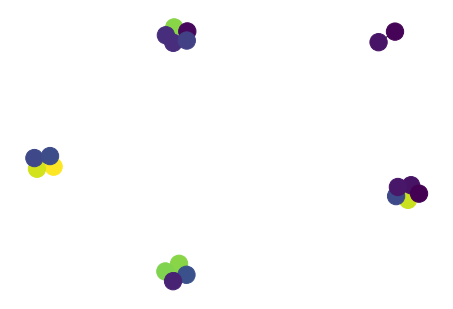

[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
                       0          1
0   [17.727350755167564]  15.888155
1   [15.859326575161054]  13.352691
2    [19.26465904742651]  10.289765
3   [15.901117053967454]   8.349282
4    [17.94350025061847]   9.408993
5   [15.603874503510516]   8.151121
6    [2.773493752303742]   4.101445
7    [4.963525873735796]   8.151121
8    [2.664800067471699]   4.128618
9    [4.460695487448303]   5.938164
10  [1.2104681284607655]   5.236198
11    [2.08810369535688]  10.068069
12   [4.339727419191714]   9.610144
13   [1.431651205437282]   5.180903
14  [0.6884983184644466]   5.610844
15  [0.2539680116698967]   5.953573
16   [4.641454358071079]   9.408993
17  [3.8997507112121594]   4.383009


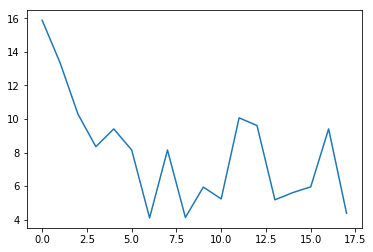

8.151120662795098 10.005131201997035
______NOOKS_________
DAY 0


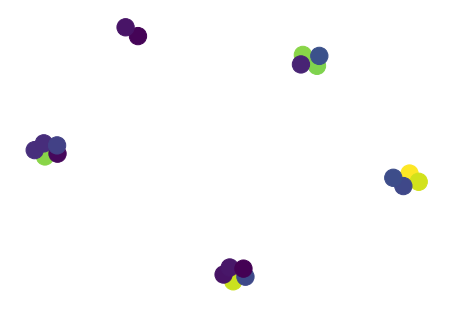

______NETWORK_________


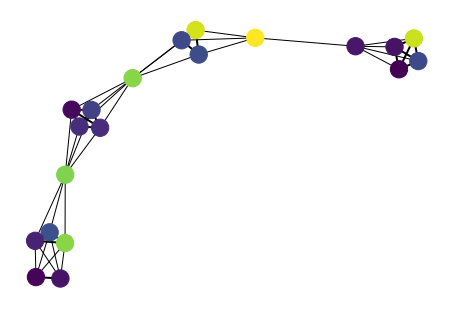

[2. 2. 1. 2.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 2. 1. 2.]
[1. 1. 2. 2.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 2. 2. 2.]
[1. 1. 2. 1.]
[2. 1. 1. 1. 2.]
[1. 2. 1. 1.]
[1. 1. 2. 2. 2.]
[2. 2. 1. 2.]
[2. 2. 1. 2.]
[2. 1. 1. 2. 1.]
[1. 1. 2. 2.]
[1. 1. 1. 1. 1.]
[1. 1. 2. 2. 2.]
[2. 2. 2. 1.]
[1. 1. 2. 2.]
[1. 1. 2. 2. 2.]
                        0          1
0    [17.727350755167564]  15.888155
1    [15.859326575161054]  12.986073
2     [19.26465904742651]  12.175576
3    [15.901117053967454]  11.035271
4     [17.94350025061847]   7.577788
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   5.847232
7   [0.41013089019082294]   5.643955
8     [4.963525873735796]   6.541337
9    [1.2635963070241618]   5.003856
10    [2.664800067471699]   5.890709
11    [4.460695487448303]   5.938164
12   [1.2104681284607655]   5.236198
13     [2.08810369535688]   6.541337
14    [4.339727419191714]  10.087508
15    [1.431651205437282]   7.711324
16   [0.6884983184644466]   7.471751
17   [0.2539

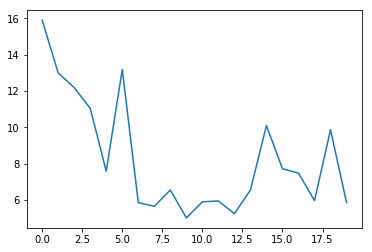

7.0065440555978835 9.772766305661396
______NOOKS_________
DAY 1


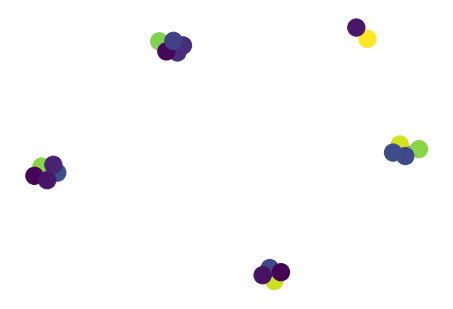

______NETWORK_________


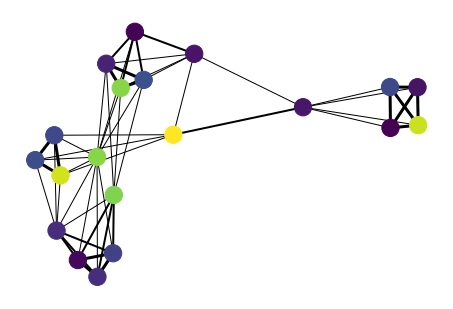

[3. 3. 1. 3.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 2. 1.]
[1. 1. 2. 3. 1. 3.]
[1. 1. 1. 3. 3.]
[1. 2. 1. 1. 1. 2. 2.]
[2. 1. 2. 3. 3.]
[2. 1. 2. 2. 2.]
[3. 1. 2. 1. 1. 3.]
[1. 1. 2. 1. 1. 1.]
[1. 1. 2. 1. 1. 2. 1. 2.]
[3. 3. 1. 3.]
[3. 3. 1. 3.]
[3. 1. 2. 3. 1. 1.]
[1. 3. 1. 1. 3.]
[1. 2. 1. 1. 1. 1.]
[2. 3. 2. 1. 3.]
[3. 3. 3. 1.]
[1. 3. 1. 3. 1.]
[2. 3. 2. 3. 1.]
                        0          1
0    [17.727350755167564]  15.888155
1    [15.859326575161054]  14.134321
2     [19.26465904742651]  13.340673
3    [15.901117053967454]  11.035271
4     [17.94350025061847]   9.117970
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   5.847232
7   [0.41013089019082294]   7.605003
8     [4.963525873735796]   7.980512
9    [1.2635963070241618]   7.603297
10    [2.664800067471699]   6.358635
11    [4.460695487448303]   5.938164
12   [1.2104681284607655]   5.236198
13     [2.08810369535688]   9.130680
14    [4.339727419191714]   8.404992
15    [1.431651205437282]   7.71

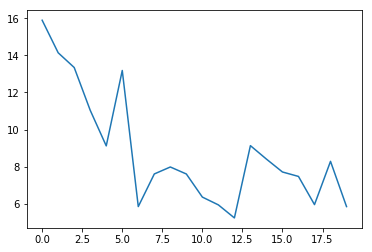

7.845917561782995 9.150397836920174
______NOOKS_________
DAY 2


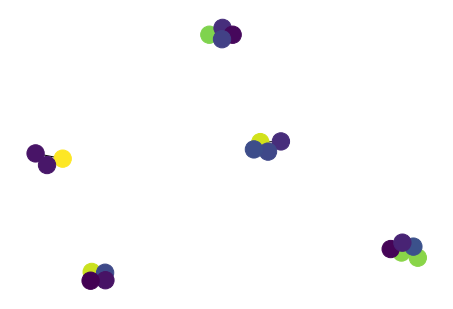

______NETWORK_________


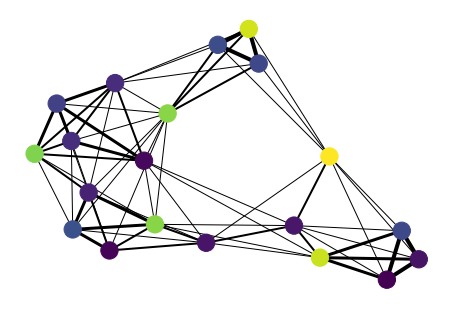

[1. 1. 3. 3. 2. 1. 3.]
[2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 1. 1.]
[1. 1. 1. 2. 3. 2. 3. 1. 1.]
[2. 1. 1. 4. 4.]
[1. 2. 1. 2. 2. 2. 3.]
[2. 1. 1. 1. 2. 3. 3.]
[2. 1. 1. 3. 2. 2.]
[3. 1. 1. 3. 1. 1. 3.]
[1. 1. 2. 2. 1. 1. 2. 1.]
[1. 2. 2. 1. 1. 1. 2. 1. 3.]
[3. 1. 4. 1. 4.]
[3. 1. 4. 1. 4.]
[3. 2. 2. 3. 1. 1. 1. 1.]
[2. 1. 4. 1. 4.]
[2. 2. 1. 2. 1. 1. 1. 1.]
[1. 1. 2. 3. 1. 2. 1. 1. 3.]
[3. 1. 4. 4. 1.]
[2. 1. 4. 1. 4.]
[3. 3. 3. 1. 3. 1.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]  11.088334
2     [19.26465904742651]  17.564777
3    [15.901117053967454]  14.018346
4     [17.94350025061847]   9.117970
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   5.847232
7   [0.41013089019082294]   7.605003
8     [4.963525873735796]   7.980512
9    [1.2635963070241618]  10.024772
10    [2.664800067471699]   6.307544
11    [4.460695487448303]   7.711324
12   [1.2104681284607655]   7.799797
13     [2.088103695356

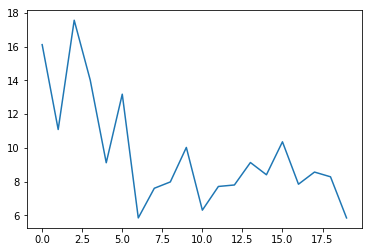

8.484994247182122 10.069475901606856
______NOOKS_________
DAY 3


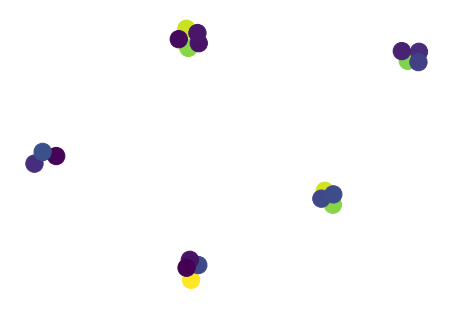

______NETWORK_________


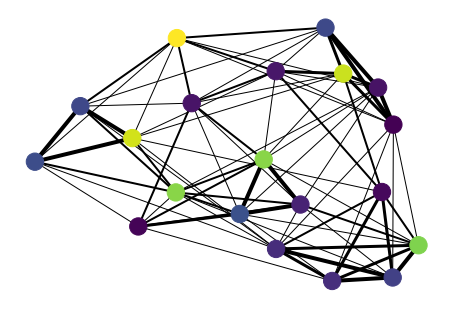

[1. 1. 1. 3. 3. 3. 2. 3.]
[2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
[1. 2. 2. 1. 2. 2. 1. 1.]
[1. 2. 2. 4. 2. 4. 1. 1. 1.]
[1. 2. 1. 1. 4. 1. 1. 4.]
[1. 3. 1. 3. 2. 2. 1. 4.]
[3. 1. 1. 1. 3. 3. 1. 4.]
[2. 1. 1. 3. 2. 2. 1.]
[2. 4. 1. 1. 3. 1. 1. 4.]
[1. 2. 2. 2. 1. 2. 1. 1. 1.]
[1. 3. 3. 2. 4. 1. 1. 1. 1.]
[3. 2. 1. 4. 1. 1. 4.]
[3. 1. 1. 4. 1. 1. 1. 1. 4.]
[2. 4. 2. 2. 4. 1. 1. 1. 1.]
[2. 2. 4. 1. 1. 1. 4.]
[3. 2. 1. 2. 1. 1. 1. 2. 1.]
[2. 1. 2. 3. 2. 2. 3.]
[3. 1. 1. 1. 4. 4. 1. 1. 1.]
[2. 1. 4. 1. 4. 1.]
[4. 4. 4. 1. 3. 1. 1.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]   9.897734
2     [19.26465904742651]  16.914731
3    [15.901117053967454]  10.984180
4     [17.94350025061847]  12.551369
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   5.847232
7   [0.41013089019082294]   7.605003
8     [4.963525873735796]   7.980512
9    [1.2635963070241618]  10.024772
10    [2.664800067471699]   6.307544
11    [4.460695487448303]   7.

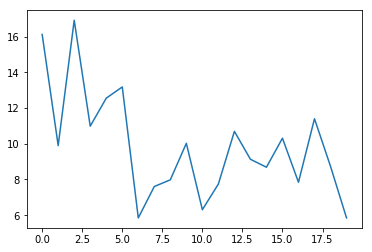

9.514207065985953 8.845043661307134
______NOOKS_________
DAY 4


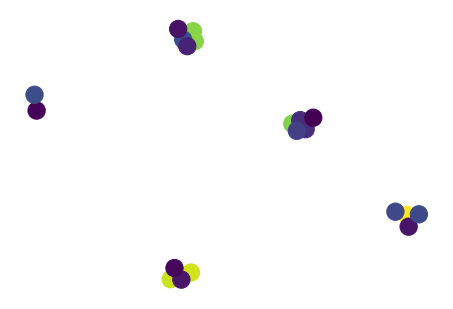

______NETWORK_________


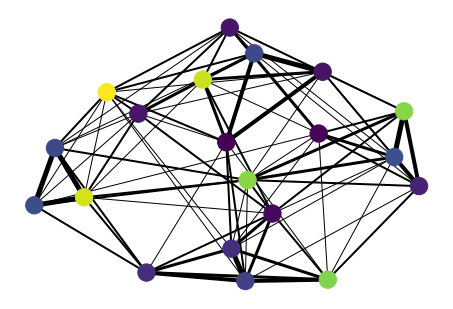

[2. 3. 3. 3. 2. 3. 1. 1.]
[3. 2. 3. 2. 2. 2. 2. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 1. 1. 1. 1. 1.]
[3. 2. 5. 2. 4. 2. 1.]
[2. 1. 1. 2. 5. 2. 1. 5.]
[3. 3. 2. 2. 4. 1. 1. 1.]
[3. 1. 1. 1. 1. 3. 3. 2. 5.]
[2. 1. 1. 1. 1. 3. 3. 2. 1.]
[3. 5. 1. 3. 1. 1. 1. 4. 1.]
[2. 2. 2. 3. 1. 2. 1. 1.]
[2. 3. 3. 2. 2. 2. 4. 1.]
[3. 2. 1. 5. 1. 1. 1. 4.]
[3. 1. 5. 1. 1. 1. 2. 1. 4.]
[2. 4. 2. 2. 4. 1. 2. 1.]
[2. 2. 5. 2. 1. 1. 1. 5.]
[3. 2. 2. 2. 1. 1. 1. 2. 1. 1.]
[2. 2. 2. 1. 2. 3. 1. 2. 2. 3.]
[3. 2. 2. 4. 4. 1. 1. 1. 2.]
[2. 5. 1. 2. 5. 1. 1.]
[4. 5. 4. 3. 2. 1. 1. 1.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]  10.279848
2     [19.26465904742651]  16.914731
3    [15.901117053967454]  11.099200
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   3.733971
7   [0.41013089019082294]   7.978608
8     [4.963525873735796]   7.980512
9    [1.2635963070241618]  10.024772
10    [2.664800067471699]   6.307615


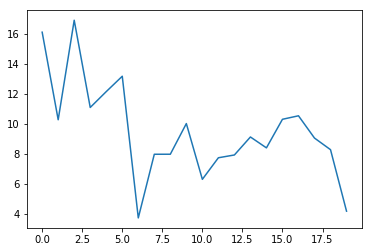

9.094648610147917 10.467221759439132
______NOOKS_________
DAY 5


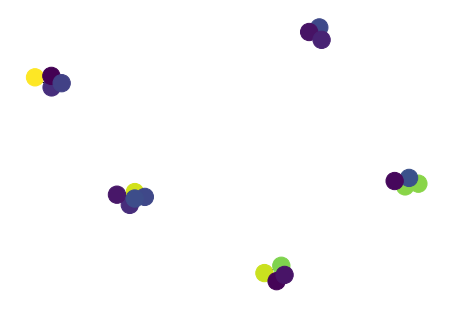

______NETWORK_________


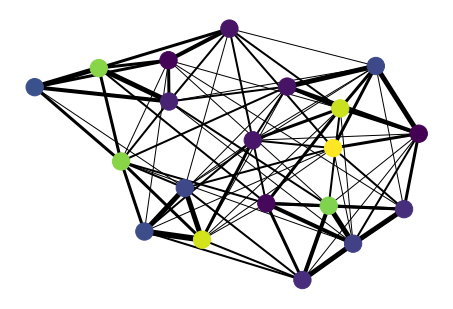

[2. 2. 3. 3. 3. 3. 3. 1. 1. 1.]
[3. 3. 3. 2. 2. 2. 2. 3. 1. 1.]
[2. 2. 3. 2. 2. 3. 1. 1. 1.]
[3. 3. 5. 3. 5. 2.]
[3. 1. 1. 2. 1. 5. 3. 1. 6.]
[2. 3. 4. 2. 3. 5. 1. 1.]
[2. 3. 3. 3. 3. 5. 1. 1.]
[3. 1. 1. 1. 1. 3. 4. 3. 1.]
[3. 5. 3. 4. 1.]
[2. 2. 3. 4. 2. 2. 1. 1.]
[2. 4. 3. 2. 3. 2. 5. 1.]
[3. 3. 1. 1. 5. 1. 1. 1. 5.]
[3. 2. 1. 5. 2. 2. 4. 1.]
[2. 5. 2. 3. 4. 2. 1. 2. 1.]
[2. 2. 5. 2. 1. 1. 1. 1. 5.]
[3. 2. 3. 2. 1. 2. 1. 2. 2. 1.]
[3. 2. 2. 1. 3. 3. 3. 2. 4.]
[3. 3. 3. 5. 4. 1. 1. 1. 2.]
[3. 6. 1. 2. 5. 2. 1. 1.]
[5. 5. 5. 4. 2. 1. 1. 1. 1.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]   7.882093
2     [19.26465904742651]  17.227978
3    [15.901117053967454]  10.984180
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   3.733971
7   [0.41013089019082294]   7.978608
8     [4.963525873735796]   5.977201
9    [1.2635963070241618]  10.156062
10    [2.664800067471699]   6.307544
11    

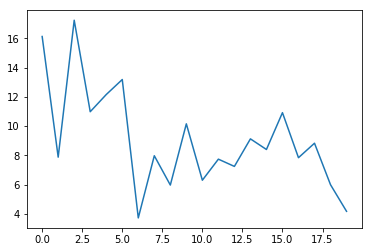

8.191799714052802 11.976121157742476
______NOOKS_________
DAY 6


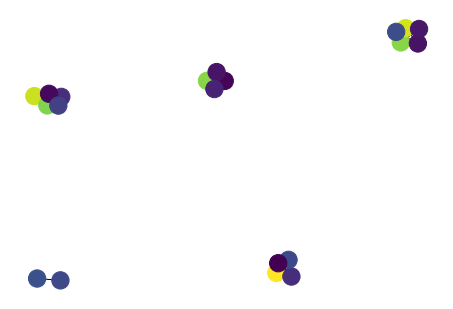

______NETWORK_________


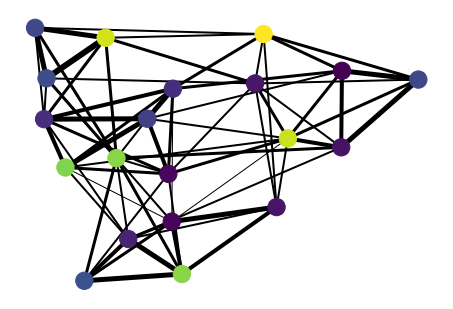

[2. 2. 3. 4. 3. 3. 3. 2. 1.]
[3. 3. 3. 3. 2. 3. 2. 3. 2. 1.]
[2. 3. 2. 3. 2. 2. 3.]
[3. 4. 5. 4. 5. 2.]
[3. 2. 3. 5. 3. 6.]
[2. 3. 4. 2. 3. 5. 1.]
[3. 3. 4. 3. 3. 5. 1.]
[4. 1. 1. 1. 1. 3. 5. 3. 2.]
[3. 5. 3. 4. 2.]
[2. 2. 4. 5. 2. 2.]
[3. 4. 4. 2. 2. 3. 2. 5.]
[3. 3. 5. 2. 5.]
[4. 3. 5. 2. 2. 4.]
[2. 5. 2. 3. 4. 2. 2. 2.]
[3. 2. 5. 2. 5.]
[3. 2. 3. 2. 2. 2. 2. 2.]
[3. 2. 2. 3. 3. 2. 3. 2. 4.]
[3. 3. 3. 5. 4. 2.]
[3. 6. 2. 2. 5. 2.]
[2. 2. 5. 5. 5. 4. 2.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]  10.073261
2     [19.26465904742651]  17.227978
3    [15.901117053967454]  10.984180
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.180945
6     [2.773493752303742]   6.615204
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   6.707447
9    [1.2635963070241618]  10.156062
10    [2.664800067471699]   6.307544
11    [4.460695487448303]   7.711324
12   [1.2104681284607655]   7.250021
13     [2.088103695356

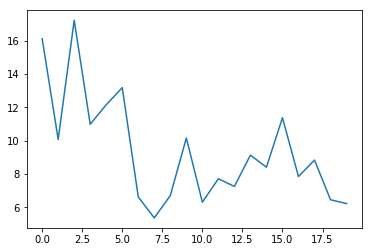

8.619178501868767 10.334489559482154
______NOOKS_________
DAY 7


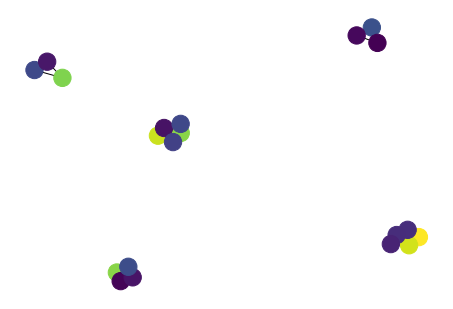

______NETWORK_________


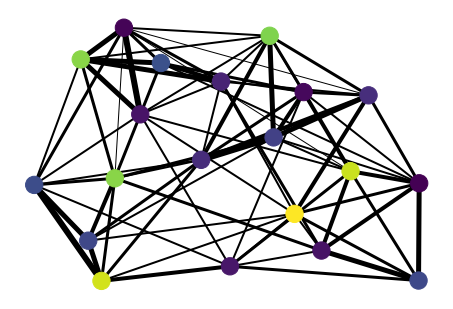

[2. 2. 3. 4. 3. 4. 4. 2. 1.]
[3. 3. 3. 3. 4. 3. 3. 1. 2.]
[2. 4. 2. 3. 2. 2. 2. 2. 3.]
[3. 2. 5. 5. 5. 5. 2. 2.]
[3. 2. 3. 5. 4. 6.]
[2. 2. 3. 2. 2. 4. 2. 3. 5.]
[4. 3. 4. 2. 3. 3. 5. 1.]
[5. 2. 1. 1. 1. 3. 6. 3. 3.]
[3. 5. 3. 4. 3. 2.]
[2. 2. 5. 2. 6. 2. 2. 2.]
[3. 4. 4. 2. 2. 3. 3. 2. 6.]
[3. 3. 5. 3. 5.]
[4. 3. 2. 5. 3. 2. 4.]
[2. 5. 2. 2. 3. 4. 2. 2. 3.]
[4. 2. 5. 3. 5. 2.]
[3. 2. 4. 2. 3. 2. 2. 2.]
[4. 2. 3. 3. 3. 3. 2. 4. 2.]
[4. 3. 3. 2. 5. 4. 2. 2.]
[3. 2. 6. 3. 2. 2. 5. 2.]
[2. 3. 5. 5. 6. 2. 4. 2.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]  12.048341
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  10.984180
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.516540
6     [2.773493752303742]   6.615204
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   6.707447
9    [1.2635963070241618]  12.859216
10    [2.664800067471699]   6.307544
11    [4.460695487448303]   7.711324
12   

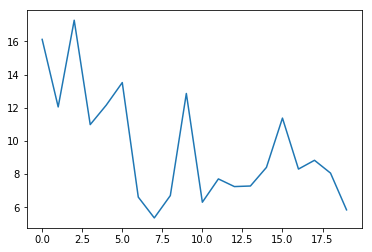

8.355046190983781 11.27662553118611
______NOOKS_________
DAY 8


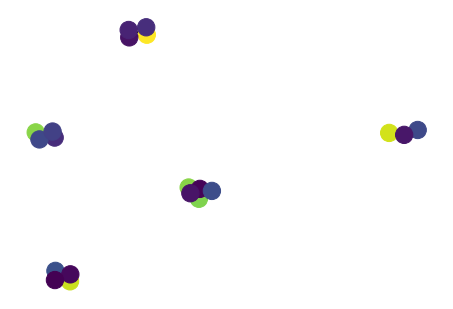

______NETWORK_________


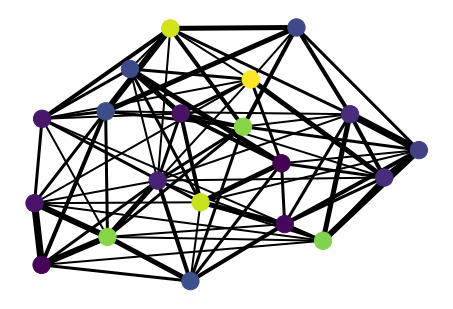

[2. 2. 2. 3. 4. 3. 5. 5. 2.]
[3. 4. 3. 3. 3. 4. 3. 3. 2.]
[2. 5. 2. 3. 3. 2. 2. 2. 3.]
[3. 2. 6. 5. 6. 5. 2. 2. 3.]
[4. 2. 3. 2. 2. 5. 4. 6.]
[2. 2. 3. 2. 2. 5. 2. 3. 6.]
[5. 3. 4. 2. 2. 3. 3. 5.]
[6. 2. 3. 7. 3. 4.]
[2. 3. 5. 3. 4. 4. 3.]
[2. 2. 6. 2. 7. 2. 3. 3.]
[3. 5. 4. 2. 2. 4. 3. 2. 7.]
[3. 3. 2. 5. 2. 3. 5.]
[4. 3. 3. 2. 5. 3. 2. 4.]
[3. 2. 5. 2. 2. 2. 3. 4. 2. 2. 2. 3.]
[4. 2. 5. 4. 5. 3.]
[3. 2. 2. 4. 3. 3. 2. 2. 3.]
[5. 2. 3. 3. 4. 3. 2. 3. 4.]
[5. 3. 3. 3. 5. 4. 3. 2.]
[3. 3. 6. 4. 3. 2. 5. 3.]
[2. 3. 6. 5. 7. 3. 4. 2.]
                        0          1
0    [17.727350755167564]  16.118295
1    [15.859326575161054]  10.796686
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.516540
6     [2.773493752303742]   6.615204
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   6.738680
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   6.247269
11    [4.460695487

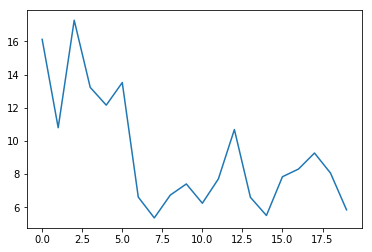

7.952708214026276 11.923407065611375
______NOOKS_________
DAY 9


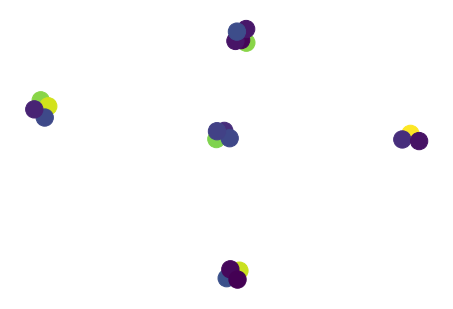

______NETWORK_________


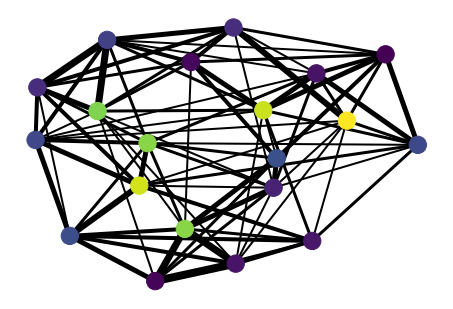

[3. 3. 5. 3. 5. 5. 3. 2. 2. 2.]
[3. 5. 3. 3. 3. 3. 4. 3. 3. 2.]
[2. 6. 2. 3. 3. 2. 2. 2. 3.]
[3. 2. 7. 5. 7. 5. 3. 2. 4.]
[5. 2. 4. 3. 2. 5. 4. 6.]
[3. 2. 3. 5. 3. 7. 2. 2. 2.]
[6. 3. 4. 2. 2. 4. 3. 5.]
[7. 2. 3. 8. 3. 2. 5.]
[3. 5. 3. 2. 5. 4. 4.]
[2. 7. 8. 2. 2. 2. 4. 4.]
[3. 4. 5. 4. 2. 4. 3. 2. 7.]
[3. 3. 3. 2. 5. 2. 3. 5.]
[5. 3. 3. 2. 5. 3. 4. 2. 2.]
[3. 2. 5. 2. 2. 3. 5. 2. 2. 2. 3.]
[4. 2. 5. 4. 2. 2. 2. 5. 4.]
[3. 2. 3. 4. 2. 4. 3. 4.]
[5. 2. 3. 4. 4. 3. 3. 4.]
[5. 3. 3. 4. 5. 4. 3. 2.]
[3. 4. 6. 5. 4. 2. 5. 4.]
[3. 3. 7. 5. 7. 4. 4. 2. 2.]
                        0          1
0    [17.727350755167564]  16.230483
1    [15.859326575161054]  11.043676
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  10.902486
6     [2.773493752303742]   6.528298
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   6.738680
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   6.247269


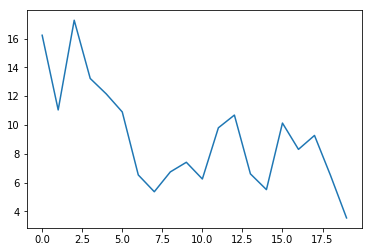

8.7882363237497 12.481443613137117
______NOOKS_________
DAY 10


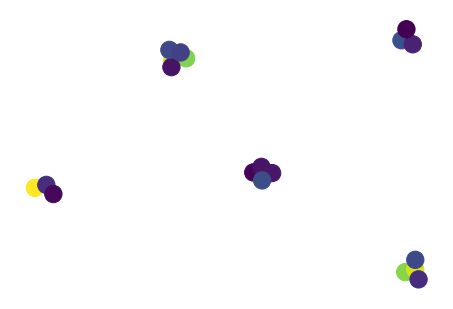

______NETWORK_________


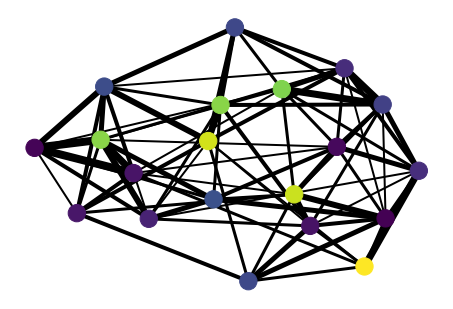

[3. 3. 3. 5. 3. 5. 6. 3. 2.]
[3. 6. 3. 3. 4. 3. 4. 3. 4.]
[7. 3. 3. 3. 3. 2.]
[3. 2. 8. 5. 7. 6. 3. 2. 5.]
[6. 2. 4. 3. 2. 2. 5. 4. 6.]
[3. 2. 3. 5. 3. 3. 7. 2. 2.]
[7. 3. 4. 2. 2. 5. 3. 5.]
[8. 2. 3. 8. 4. 2. 6.]
[3. 3. 5. 3. 5. 4. 5.]
[3. 7. 8. 2. 2. 2. 4. 2. 4.]
[3. 4. 5. 4. 4. 3. 7. 2. 2.]
[3. 3. 3. 5. 4. 5.]
[5. 4. 3. 2. 2. 5. 3. 4. 3.]
[3. 6. 2. 2. 4. 5. 2. 3.]
[4. 5. 3. 4. 5. 4.]
[3. 3. 4. 2. 4. 4. 4.]
[5. 2. 3. 5. 4. 2. 3. 3. 4.]
[6. 3. 3. 5. 5. 4. 3. 2. 2.]
[3. 5. 6. 6. 4. 5. 4. 2.]
[3. 4. 7. 5. 7. 3. 4. 4. 2.]
                        0          1
0    [17.727350755167564]  16.230483
1    [15.859326575161054]  10.796686
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  12.730620
6     [2.773493752303742]   6.528298
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   7.112285
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   6.247269
11    [4.460695487448303]   7.

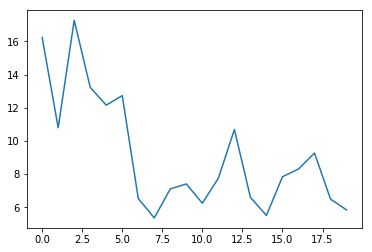

7.7987218367894755 11.929337673840696
______NOOKS_________
DAY 11


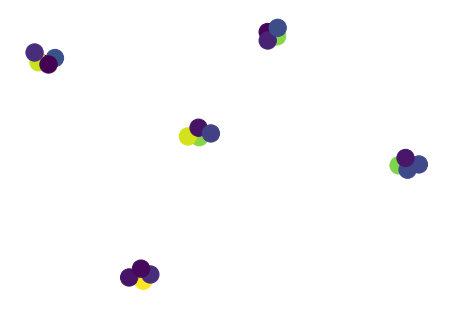

______NETWORK_________


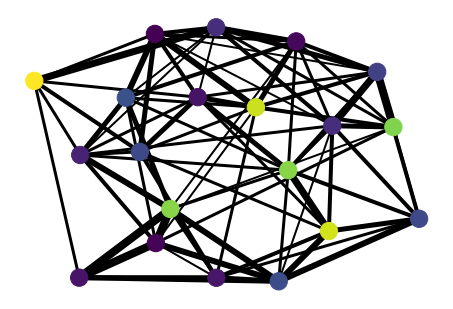

[4. 3. 3. 5. 3. 5. 6. 4. 2.]
[7. 5. 4. 4. 3. 3. 3. 3. 3. 3.]
[7. 3. 4. 3. 3. 3.]
[3. 2. 8. 5. 8. 6. 4. 2. 6.]
[7. 4. 3. 3. 5. 4. 6.]
[4. 2. 3. 3. 5. 3. 3. 8.]
[7. 3. 2. 4. 2. 2. 5. 4. 5.]
[8. 3. 2. 3. 8. 4. 2. 6.]
[3. 5. 2. 3. 3. 5. 4. 6.]
[3. 8. 8. 5. 5.]
[4. 5. 4. 3. 3. 4. 3. 7. 2. 2.]
[3. 4. 3. 5. 3. 4. 5.]
[5. 5. 3. 3. 2. 5. 3. 4. 3.]
[3. 6. 2. 4. 5. 3. 3. 3. 3.]
[4. 5. 3. 4. 3. 6. 4.]
[3. 4. 4. 2. 5. 4. 3. 5.]
[5. 2. 3. 5. 4. 3. 3. 3. 4.]
[6. 3. 4. 6. 5. 4. 3. 2. 2.]
[6. 6. 6. 5. 6. 5. 3. 2.]
[4. 4. 8. 5. 7. 3. 4. 4. 2.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  11.076607
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  11.375159
6     [2.773493752303742]   4.466127
7   [0.41013089019082294]   7.489498
8     [4.963525873735796]   7.112285
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   6.247269
11    [4.460695487448303

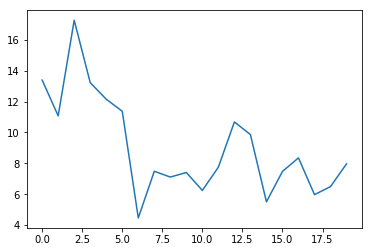

7.862527474277687 9.926660388720919
______NOOKS_________
DAY 12


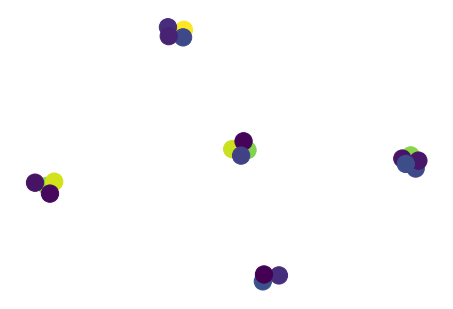

______NETWORK_________


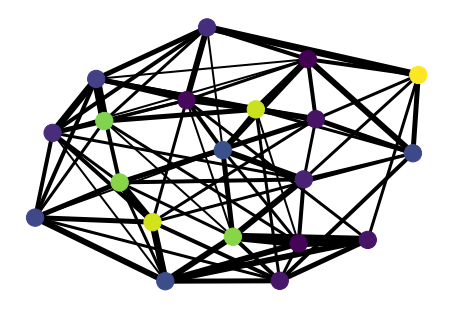

[5. 3. 3. 6. 3. 5. 6. 5. 2.]
[7. 4. 5. 4. 5. 4. 3. 3. 3.]
[7. 3. 5. 3. 3. 4.]
[3. 2. 8. 5. 8. 6. 4. 2. 6.]
[7. 4. 3. 3. 5. 4. 3. 7.]
[5. 2. 3. 3. 5. 3. 3. 9.]
[7. 3. 4. 6. 4. 5. 2.]
[8. 3. 2. 3. 8. 4. 3. 6.]
[3. 4. 5. 3. 2. 6. 2. 4. 6.]
[3. 8. 8. 5. 3. 6.]
[4. 5. 4. 3. 3. 4. 3. 7. 2. 2.]
[3. 5. 3. 5. 3. 4. 6.]
[6. 5. 3. 3. 5. 3. 4. 4.]
[4. 3. 6. 4. 6. 3. 3. 3.]
[5. 5. 3. 2. 4. 3. 6. 4.]
[3. 4. 4. 3. 5. 4. 3. 5.]
[5. 2. 3. 3. 6. 4. 3. 3. 4. 3.]
[6. 4. 4. 6. 6. 4. 2. 3. 2.]
[6. 7. 6. 6. 6. 5. 3. 2.]
[5. 4. 9. 5. 7. 4. 4. 4. 2.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  10.796686
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  11.375159
6     [2.773493752303742]   4.466127
7   [0.41013089019082294]   7.489498
8     [4.963525873735796]   6.738680
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   6.247269
11    [4.460695487448303

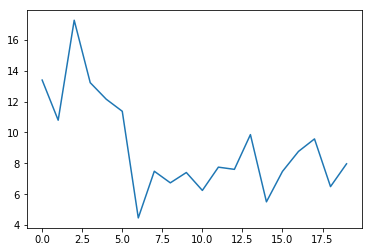

7.862527474277687 9.442825913009788
______NOOKS_________
DAY 13


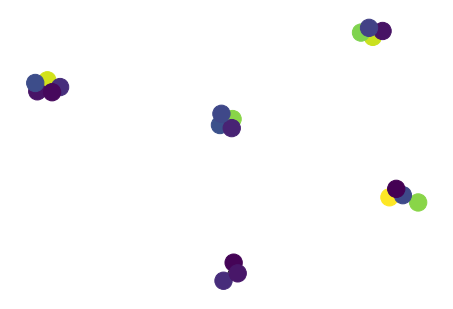

______NETWORK_________


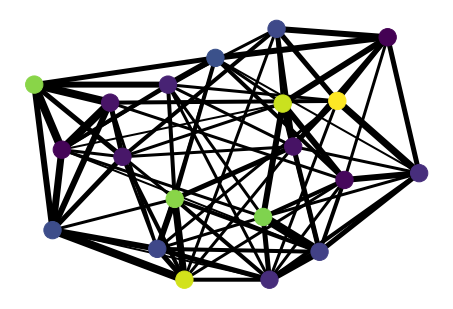

[6. 3. 3. 6. 3. 6. 6. 5. 2.]
[7. 4. 4. 5. 4. 6. 4. 3. 3.]
[7. 4. 3. 5. 3. 3. 3. 4.]
[3. 8. 5. 8. 6. 5. 6.]
[7. 4. 3. 3. 5. 4. 3. 8.]
[6. 3. 3. 5. 3. 3. 4. 9.]
[7. 3. 4. 3. 6. 5. 5. 2.]
[8. 3. 2. 3. 8. 4. 3. 7. 2.]
[3. 4. 5. 3. 2. 6. 2. 4. 6.]
[4. 8. 8. 3. 5. 3. 6.]
[4. 3. 4. 5. 4. 3. 5. 3. 7. 2.]
[3. 5. 3. 5. 3. 4. 6.]
[6. 5. 3. 3. 3. 5. 5. 4. 3. 3.]
[4. 3. 6. 3. 4. 6. 3. 3. 3.]
[6. 3. 5. 3. 2. 3. 5. 3. 6. 4.]
[3. 5. 4. 3. 5. 4. 3. 3. 5.]
[6. 3. 4. 6. 4. 3. 3. 4. 3.]
[6. 4. 5. 6. 6. 5. 3.]
[6. 8. 7. 6. 6. 5. 3. 2.]
[5. 4. 9. 5. 2. 7. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  11.043676
2     [19.26465904742651]  17.272215
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  11.375159
6     [2.773493752303742]   4.466127
7   [0.41013089019082294]   7.489498
8     [4.963525873735796]   6.738680
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   8.864436
11    

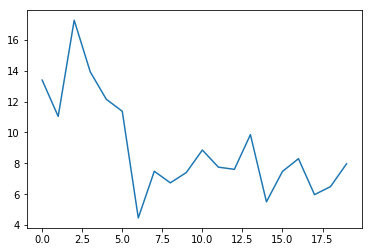

7.862527474277687 9.901939588520566
______NOOKS_________
DAY 14


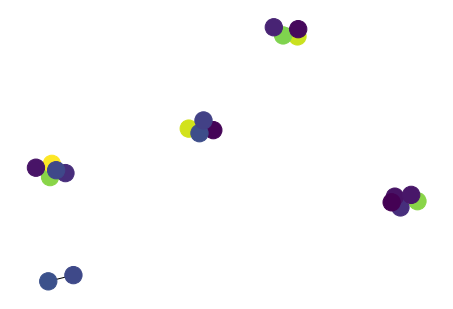

______NETWORK_________


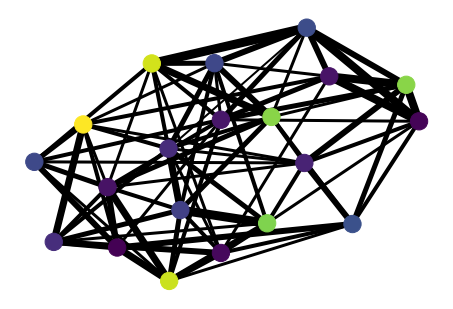

[6. 3. 3. 7. 4. 6. 7. 5.]
[7. 4. 4. 5. 4. 6. 5. 3. 3.]
[7. 4. 4. 5. 3. 3. 3. 4.]
[3. 8. 5. 8. 6. 5. 6.]
[7. 4. 4. 3. 5. 4. 3. 9.]
[6. 3. 3. 5. 4. 4. 5. 9.]
[7. 3. 4. 4. 6. 6. 5.]
[8. 3. 4. 8. 4. 3. 8.]
[3. 4. 5. 4. 6. 4. 6.]
[4. 8. 8. 3. 5. 3. 6.]
[4. 4. 4. 5. 4. 3. 5. 3. 7. 2.]
[3. 5. 4. 5. 3. 4. 6.]
[7. 5. 3. 3. 4. 5. 4. 6. 4. 3.]
[4. 3. 6. 4. 4. 6. 3. 3. 3.]
[6. 3. 5. 4. 3. 5. 3. 6. 4.]
[4. 5. 4. 3. 5. 4. 4. 3. 5. 3.]
[6. 3. 5. 6. 4. 3. 3. 4. 3.]
[7. 4. 6. 6. 6. 6. 3. 3.]
[6. 9. 8. 6. 6. 5. 3. 2.]
[5. 5. 9. 5. 7. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  10.796686
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   6.794353
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   9.545502
11    [4.460695487448303

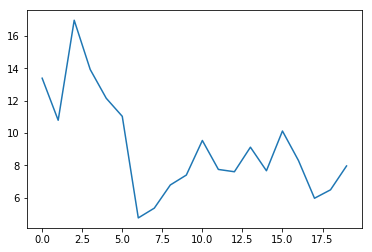

8.137801130645908 9.33309224496253
______NOOKS_________
DAY 15


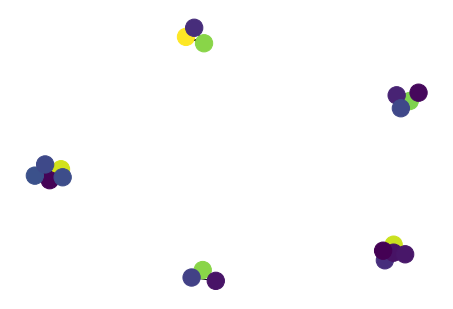

______NETWORK_________


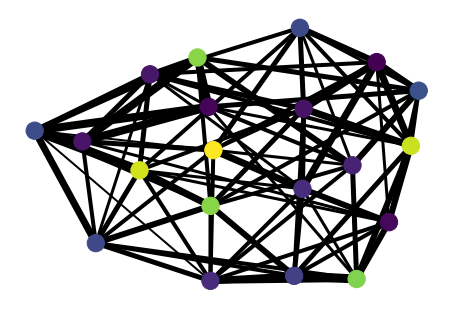

[6. 3. 4. 4. 7. 4. 6. 7. 5.]
[4. 7. 4. 4. 5. 4. 6. 6. 3.]
[7. 5. 4. 5. 3. 3. 4. 4. 2.]
[4. 8. 5. 8. 6. 5. 6.]
[7. 3. 4. 4. 4. 5. 5. 3. 9.]
[6. 3. 3. 6. 5. 4. 6. 9.]
[7. 3. 3. 4. 5. 3. 6. 7. 5.]
[3. 8. 3. 5. 8. 4. 3. 8.]
[4. 4. 5. 5. 3. 6. 4. 6.]
[5. 8. 8. 4. 5. 3. 7.]
[4. 4. 4. 6. 4. 4. 5. 4. 7. 2.]
[4. 5. 4. 3. 5. 3. 4. 6.]
[7. 5. 3. 4. 5. 5. 5. 7. 4.]
[4. 3. 6. 5. 4. 6. 4. 3.]
[6. 4. 5. 4. 4. 5. 3. 7. 4.]
[4. 5. 5. 3. 3. 5. 4. 5. 3. 4. 5.]
[6. 3. 6. 6. 4. 3. 4. 4. 3.]
[7. 4. 7. 6. 6. 7. 4. 3.]
[6. 9. 8. 7. 7. 5. 3. 2. 2.]
[5. 6. 9. 5. 7. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  10.796686
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  12.446975
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   5.361429
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   9.545502


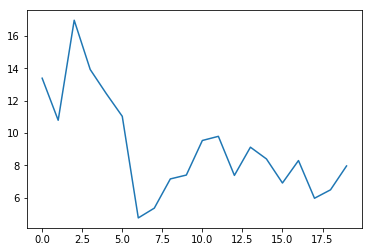

8.355046190983781 9.424853226204409
______NOOKS_________
DAY 16


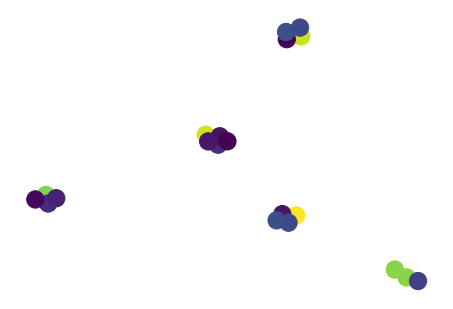

______NETWORK_________


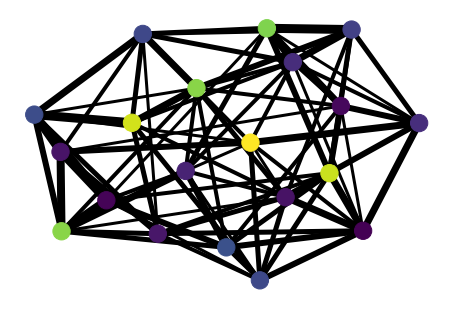

[6. 4. 5. 5. 7. 4. 6. 7. 5.]
[4. 7. 4. 4. 5. 4. 7. 4. 6. 3.]
[7. 6. 4. 5. 3. 3. 4. 4. 3.]
[4. 8. 5. 8. 3. 7. 5. 6.]
[7. 4. 5. 4. 5. 5. 9.]
[6. 3. 3. 6. 5. 5. 7. 9.]
[7. 3. 4. 6. 6. 7. 5.]
[4. 8. 3. 6. 8. 4. 8. 3.]
[5. 4. 5. 6. 4. 6. 4. 6.]
[6. 8. 8. 4. 5. 3. 8.]
[4. 4. 4. 6. 4. 4. 5. 4. 7. 3.]
[5. 5. 5. 4. 3. 5. 3. 4. 6.]
[7. 5. 3. 3. 4. 6. 5. 4. 5. 7. 4.]
[4. 3. 7. 5. 4. 6. 4. 3. 4.]
[7. 4. 5. 5. 4. 5. 3. 7. 4.]
[4. 5. 5. 5. 4. 5. 3. 5. 5.]
[6. 4. 7. 6. 4. 3. 4. 4. 3.]
[7. 4. 7. 6. 6. 7. 5. 3. 3.]
[3. 6. 9. 8. 8. 7. 5. 3.]
[5. 6. 9. 5. 7. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  13.396039
1    [15.859326575161054]  11.076607
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  11.796929
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.489278
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.407592
10    [2.664800067471699]   9.545502


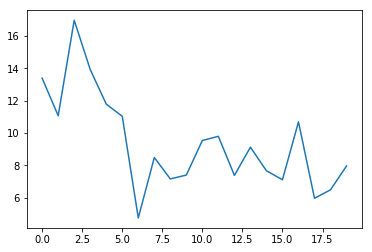

8.80997919271253 8.649696238298839
______NOOKS_________
DAY 17


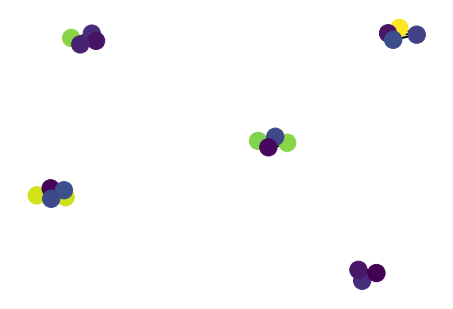

______NETWORK_________


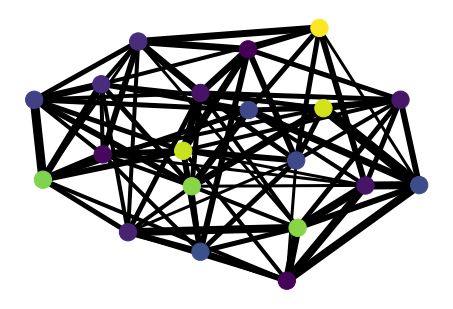

[6. 4. 6. 6. 7. 4. 6. 7. 5. 3.]
[4. 7. 4. 5. 5. 4. 7. 4. 6. 3.]
[7. 6. 4. 5. 5. 5. 3.]
[4. 3. 8. 5. 8. 4. 8. 5. 6.]
[ 7.  4.  5.  4.  5.  6.  4. 10.]
[6. 3. 4. 7. 5. 5. 7. 9.]
[7. 3. 3. 4. 7. 4. 6. 7. 5.]
[4. 8. 4. 6. 8. 4. 8. 3.]
[6. 4. 5. 6. 5. 6. 4. 6.]
[6. 8. 8. 3. 4. 5. 3. 8.]
[5. 4. 4. 7. 4. 4. 5. 4. 7.]
[6. 5. 5. 5. 3. 5. 3. 4. 6.]
[7. 5. 4. 4. 7. 5. 5. 5. 7. 4.]
[4. 8. 5. 4. 4. 6. 4. 3. 5.]
[7. 5. 5. 5. 4. 5. 3. 7. 5.]
[4. 5. 6. 5. 4. 5. 3. 5. 6.]
[6. 4. 4. 7. 6. 4. 3. 4. 4.]
[7. 5. 7. 6. 6. 7. 5.]
[ 6. 10.  8.  8.  7.  6.  3.  3.]
[5. 6. 9. 5. 7. 5. 4. 4.]
                        0          1
0    [17.727350755167564]  15.411920
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.646363
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  11.796929
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.489278
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.407592
10    [2.664800067471

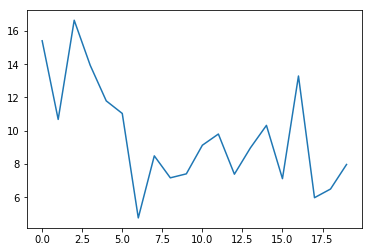

9.049640271098687 9.843114305773437
______NOOKS_________
DAY 18


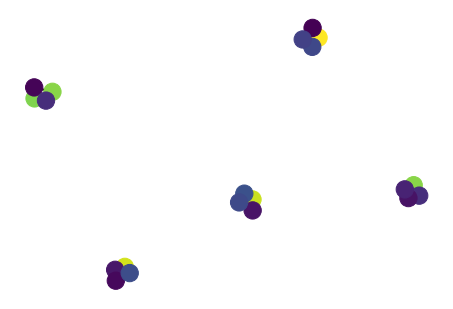

______NETWORK_________


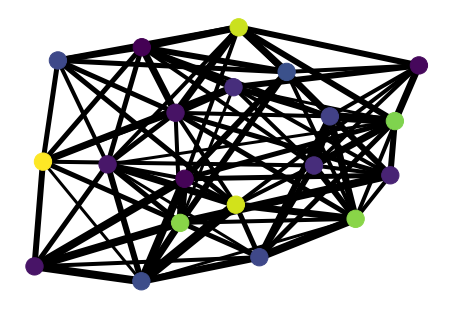

[6. 4. 7. 6. 7. 4. 6. 7. 5.]
[4. 7. 4. 6. 5. 4. 8. 4. 7. 3.]
[7. 6. 4. 5. 4. 5. 5. 3.]
[4. 3. 8. 6. 8. 4. 8. 5. 7.]
[ 7.  4.  4.  5.  4.  5.  7.  4. 10.]
[6. 3. 5. 7. 6. 5. 3. 7. 9.]
[7. 3. 3. 4. 7. 4. 6. 7. 5.]
[4. 8. 4. 5. 6. 8. 5. 4. 8.]
[7. 4. 6. 6. 5. 6. 4. 6.]
[6. 8. 8. 4. 5. 8.]
[6. 4. 4. 7. 4. 6. 8. 4. 4. 4.]
[6. 5. 5. 5. 5. 4. 6.]
[7. 5. 4. 4. 4. 7. 5. 5. 5. 7. 4.]
[4. 8. 6. 4. 5. 6. 5. 4.]
[8. 5. 5. 5. 4. 6. 3. 7. 6.]
[4. 5. 7. 3. 4. 5. 4. 5. 3. 5. 6.]
[6. 4. 4. 7. 6. 4. 4. 4.]
[7. 5. 7. 6. 6. 7. 5. 4. 4.]
[ 7. 10.  8.  8.  7.  6.  3.  3.]
[5. 7. 9. 5. 8. 6. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  15.411920
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.646363
3    [15.901117053967454]  13.227755
4     [17.94350025061847]  11.796929
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.064583
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.407592
10    [2

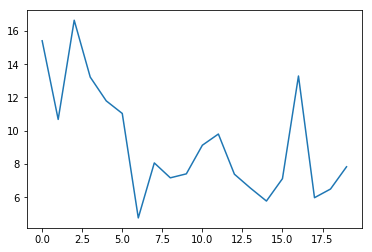

7.948914069727756 10.696780798679159
______NOOKS_________
DAY 19


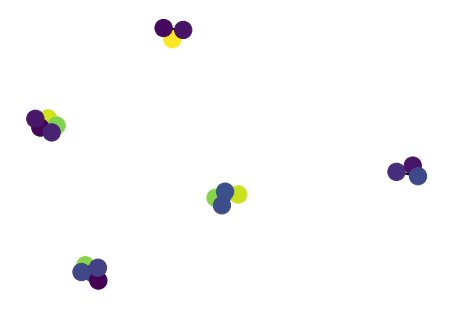

______NETWORK_________


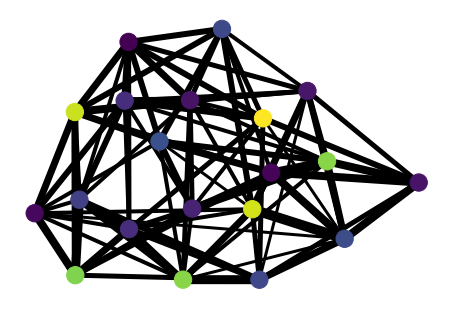

[7. 4. 7. 6. 8. 4. 7. 7. 5.]
[4. 7. 4. 6. 5. 4. 9. 4. 7. 3.]
[7. 6. 5. 5. 4. 4. 5. 6. 3.]
[4. 4. 8. 6. 8. 4. 8. 6. 7.]
[ 7.  5.  4.  6.  4.  5.  7.  4. 10.  3.]
[7. 5. 7. 6. 5. 8. 9.]
[7. 4. 4. 7. 4. 4. 6. 7. 6.]
[4. 8. 5. 5. 7. 8. 5. 8. 4.]
[7. 4. 6. 7. 3. 6. 6. 4. 6.]
[6. 8. 8. 5. 5. 8.]
[6. 5. 4. 7. 4. 5. 6. 5. 8. 4.]
[6. 5. 6. 6. 4. 5. 4. 6.]
[8. 5. 4. 4. 4. 7. 5. 5. 5. 7. 4.]
[4. 4. 8. 6. 4. 5. 6. 5. 5.]
[9. 5. 5. 5. 5. 6. 3. 7. 6.]
[4. 6. 7. 4. 5. 4. 5. 3. 5. 6.]
[7. 4. 4. 8. 6. 4. 4. 4. 3.]
[7. 6. 7. 6. 5. 6. 7. 5. 4.]
[ 7. 10.  8.  8.  7.  6.  3.  3.  3.]
[5. 7. 9. 6. 8. 6. 4. 4. 4.]
                        0          1
0    [17.727350755167564]  13.183284
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  17.005542
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  12.582849
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.532508
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.9

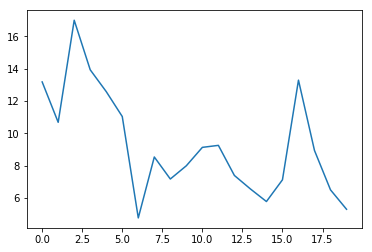

8.733219689120773 10.379341405983272
______NOOKS_________
DAY 20


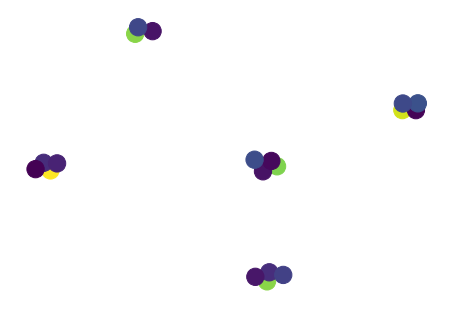

______NETWORK_________


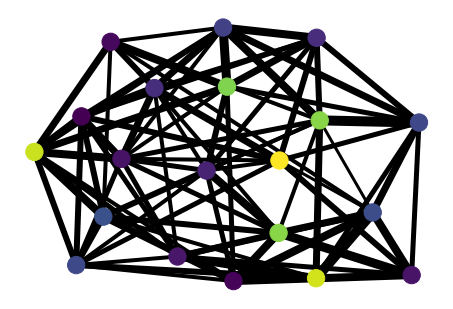

[7. 4. 8. 6. 8. 5. 7. 7. 5.]
[ 4.  7.  4.  6.  5.  4. 10.  4.  8.  3.]
[7. 6. 6. 5. 4. 4. 5. 6. 3.]
[4. 4. 8. 6. 9. 5. 8. 6. 7.]
[ 7.  5.  6.  5.  8. 10.  4.]
[7. 5. 7. 4. 6. 5. 8. 9.]
[7. 4. 4. 7. 4. 4. 6. 8. 7.]
[4. 8. 5. 5. 7. 8. 5. 8. 4.]
[8. 4. 6. 7. 4. 6. 6. 4. 6.]
[6. 9. 8. 5. 5. 8.]
[6. 6. 7. 4. 5. 6. 5. 8.]
[6. 5. 6. 6. 4. 5. 4. 4. 6.]
[8. 5. 4. 5. 4. 7. 5. 5. 5. 7. 4.]
[4. 4. 8. 6. 4. 5. 6. 5. 4. 5.]
[10.  5.  5.  5.  5.  6.  7.  7.]
[5. 6. 8. 4. 5. 4. 5. 5. 6.]
[7. 4. 8. 6. 4. 4. 4.]
[7. 6. 8. 6. 5. 6. 7. 5. 5.]
[ 7. 10.  8.  8.  7.  6.  3.  3.  4.]
[5. 8. 9. 7. 8. 7. 5. 4. 4.]
                        0          1
0    [17.727350755167564]  13.183284
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  17.005542
3    [15.901117053967454]  13.934130
4     [17.94350025061847]  12.582849
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.532508
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.9892

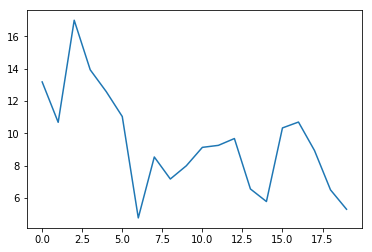

9.190631937207698 9.296526667619137
______NOOKS_________
DAY 21


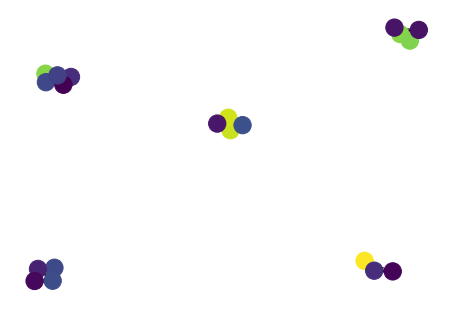

______NETWORK_________


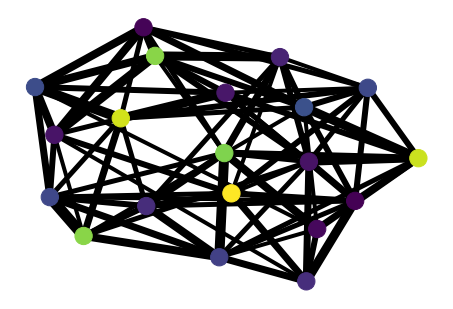

[7. 9. 6. 8. 6. 7. 7. 5.]
[ 7.  6.  5. 11.  8.  4.  4.]
[7. 6. 6. 6. 4. 4. 5. 6.]
[8. 6. 9. 6. 9. 6. 8. 4.]
[ 7.  5.  5.  5.  6.  5.  9. 10.]
[ 7.  4.  5.  7.  5.  7.  5.  8. 10.]
[7. 7. 6. 9. 7. 4.]
[8. 5. 5. 7. 8. 5. 5. 8.]
[9. 6. 5. 7. 4. 6. 6. 4. 6.]
[6. 9. 8. 4. 4. 6. 5. 8.]
[6. 6. 5. 7. 5. 6. 5. 8.]
[6. 6. 6. 5. 6. 5. 4. 4. 6.]
[8. 5. 4. 6. 5. 7. 5. 6. 7. 5. 5.]
[4. 9. 7. 5. 6. 5. 4. 6.]
[11.  5.  5.  5.  6.  6.  4.  7.  7.]
[6. 6. 9. 5. 4. 5. 5. 6.]
[7. 8. 6. 4. 4. 4.]
[7. 6. 9. 6. 5. 6. 7. 4. 5. 5.]
[ 8. 10.  8.  8.  7.  6.  4.]
[ 5.  8. 10.  7.  8.  7.  5.  5.  4.]
                        0          1
0    [17.727350755167564]  13.183284
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.582849
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.532508
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]   7.989208
10    [2.664

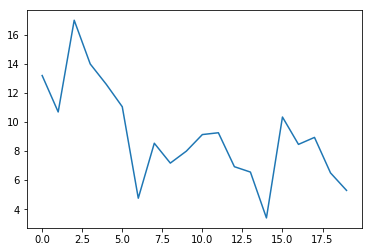

8.733219689120773 10.604949188867497
______NOOKS_________
DAY 22


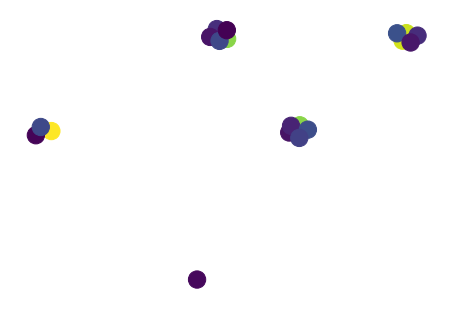

______NETWORK_________


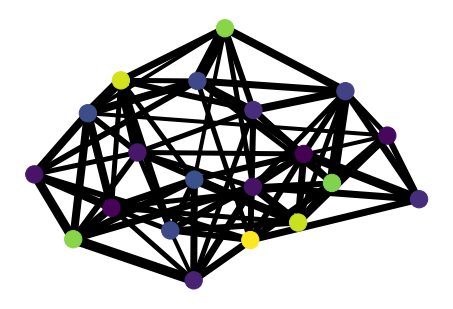

[7. 5. 9. 6. 8. 6. 7. 7. 5.]
[ 7.  6.  5. 12.  8.  4.  4.]
[7. 6. 6. 6. 4. 4. 5. 6.]
[ 8.  7.  9.  7. 10.  6.  8.]
[ 7.  5.  5.  6.  7.  5. 10. 10.]
[ 7.  5.  7.  5.  7.  5.  9. 11.]
[7. 7. 6. 9. 7.]
[5. 8. 5. 5. 7. 8. 5. 5. 8.]
[9. 7. 5. 7. 4. 6. 7. 4. 6.]
[6. 9. 8. 6. 5. 8.]
[6. 6. 6. 7. 5. 6. 5. 5. 8.]
[6. 6. 7. 5. 6. 5. 4. 5. 6.]
[8. 5. 4. 7. 5. 7. 5. 7. 7. 5. 5.]
[ 4. 10.  7.  5.  7.  5.  4.  7.]
[12.  5.  5.  5.  6.  6.  4.  8.  7.]
[ 6.  6. 10.  5.  5.  5.  5.  5.  6.]
[7. 9. 6. 4. 5. 4.]
[7. 6. 9. 6. 5. 6. 7. 4. 5. 6.]
[ 8. 10.  8.  8.  8.  6.  4.  4.]
[ 5.  8. 11.  7.  8.  7.  5.  6.  5.]
                        0          1
0    [17.727350755167564]  13.183284
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.131915
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.532508
8     [4.963525873735796]   7.167958
9    [1.2635963070241618]

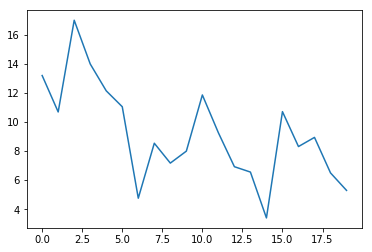

8.733219689120773 10.887925992652983
______NOOKS_________
DAY 23


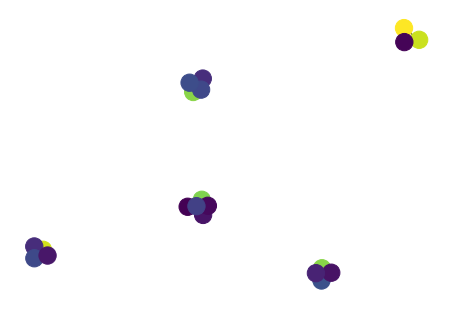

______NETWORK_________


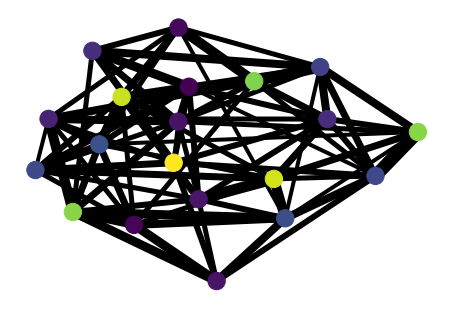

[7. 9. 6. 8. 7. 7. 8. 5. 5. 5.]
[ 7.  6.  5. 13.  8.  4.  4.]
[7. 6. 6. 7. 4. 4. 6. 6.]
[ 5.  8.  7.  9.  7. 10.  6.  9.]
[ 7.  5.  5.  5.  7.  7.  5. 11. 10.]
[ 7.  5.  7.  6.  8.  5. 10. 11.]
[7. 5. 7. 6. 9. 8.]
[8. 5. 5. 5. 7. 9. 5. 5. 8.]
[9. 7. 5. 7. 4. 6. 8. 5. 6.]
[6. 9. 9. 6. 5. 8.]
[6. 6. 7. 7. 5. 6. 6. 6. 8.]
[6. 7. 7. 5. 6. 5. 4. 5. 6.]
[8. 5. 4. 7. 6. 7. 5. 8. 7. 5. 5.]
[ 4. 10.  8.  5.  8.  5.  4.  8.  5.]
[13.  6.  5.  5.  6.  6.  4.  8.  7.]
[ 7.  6. 11.  5.  6.  5.  5.  6.  6.]
[ 7. 10.  6.  5.  5.  5.  4.]
[8. 6. 9. 6. 6. 6. 7. 4. 6. 6.]
[ 9. 10.  8.  8.  8.  6.  4.  4.  4.]
[ 8. 11.  8.  8.  7.  5.  6.  4.  5.  5.]
                        0          1
0    [17.727350755167564]  16.017728
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.131915
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   4.756994
7   [0.41013089019082294]   8.532508
8     [4.963525873735796] 

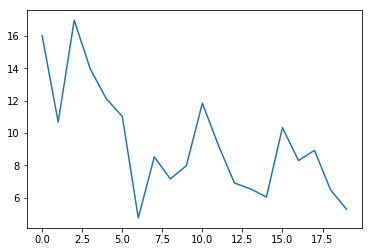

8.733219689120773 11.116404813005493
______NOOKS_________
DAY 24


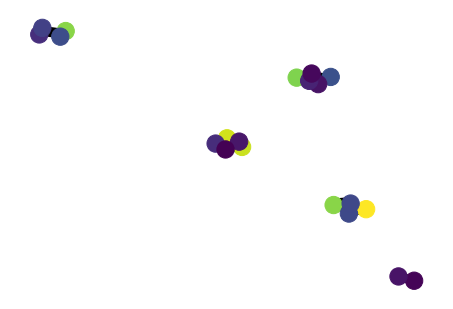

______NETWORK_________


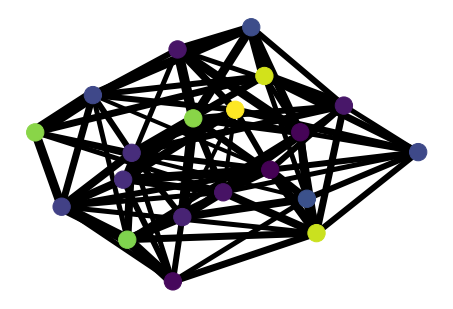

[ 7.  6. 10.  6.  8.  7.  7.  9.  5.]
[ 7.  6.  5. 13.  9.  4.]
[8. 7. 6. 7. 4. 4. 6. 6.]
[ 6.  8.  7. 10.  7. 10.  6.  9.]
[ 7.  7.  7.  6. 11. 11.  5.  5.]
[ 7.  5.  8.  6.  9.  5. 11. 11.]
[8. 6. 5. 7. 6. 9. 8.]
[6. 8. 5. 5. 8. 9. 5. 5. 8.]
[10.  7.  8.  4.  5.  6.  8.  5.  7.]
[ 7. 10.  5.  9.  6.  5.  8.]
[6. 6. 7. 8. 6. 6. 7. 6. 8. 5.]
[6. 7. 7. 5. 6. 5. 5. 6.]
[8. 5. 4. 7. 6. 7. 5. 8. 7. 5. 5.]
[ 4. 10.  9.  5.  8.  6.  8.  6.]
[13.  6.  6.  5.  6.  6.  4.  9.  7.]
[ 7.  6. 11.  5.  7.  5.  5.  6.  6.]
[ 7. 11.  6.  5.  6.  5.  5.]
[9. 6. 9. 7. 6. 6. 7. 4. 6. 6.]
[ 9. 11.  8.  8.  9.  6.]
[ 9. 11.  8.  8.  7.  5.  6.  5.  5.]
                        0          1
0    [17.727350755167564]  16.017728
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.981348
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.131915
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   6.965519
7   [0.41013089019082294]   8.489278
8     [4.963525873735796] 

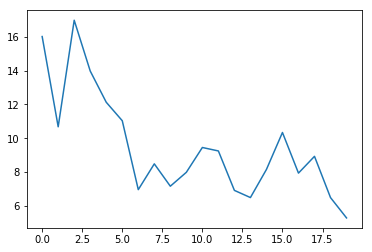

8.711604739575684 9.603322566274581
______NOOKS_________
DAY 25


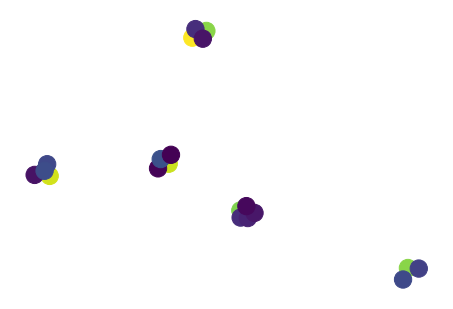

______NETWORK_________


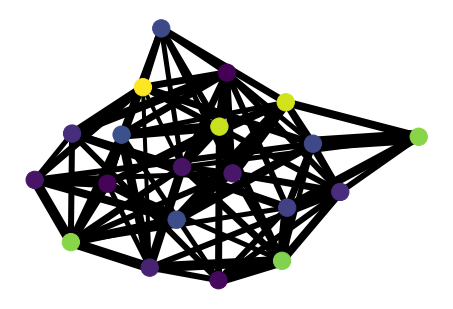

[ 6.  7.  7. 10.  6.  8.  7.  7. 10.]
[ 8.  6.  5. 14.  9.]
[8. 4. 7. 6. 7. 4. 4. 7. 7.]
[ 6.  8.  7. 10.  7. 10.  6.  9.  5.]
[ 6.  8.  6.  7.  7.  7. 11. 11.  5.]
[ 7.  5.  8.  7. 10.  5.  5. 11. 11.]
[8. 6. 5. 7. 6. 9. 8.]
[7. 4. 8. 6. 5. 8. 9. 5. 5. 8.]
[10.  7.  8.  5.  6.  9.  5.  7.]
[ 7. 10.  5.  9.  6.  5.  8.]
[6. 6. 7. 8. 7. 9. 6. 6. 6. 6.]
[6. 7. 7. 5. 6. 5. 5. 6.]
[8. 5. 4. 7. 7. 7. 5. 9. 6. 7.]
[ 4. 10. 10.  5.  9.  9.  6.  6.]
[14.  7.  7.  5.  6.  6.  5.  9.  7.]
[ 7.  6. 11.  5.  5.  7.  5.  6.  6.  6.]
[ 7. 11.  6.  5.  6.  6.  6.]
[10.  7.  9.  7.  6.  7.  5.  6.  6.  6.]
[ 9. 11.  8.  8.  9.  6.]
[ 9.  5. 11.  8.  9.  7.  6.  6.]
                        0          1
0    [17.727350755167564]  16.222033
1    [15.859326575161054]  10.681347
2     [19.26465904742651]  16.646363
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  13.493550
6     [2.773493752303742]   6.965519
7   [0.41013089019082294]   8.489278
8     [4.

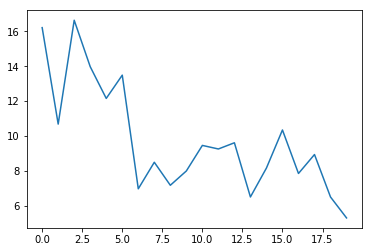

9.093263895167842 9.783423668045835
______NOOKS_________
DAY 26


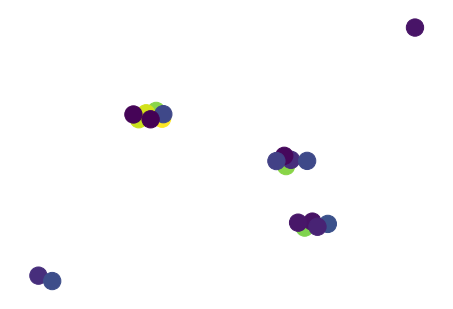

______NETWORK_________


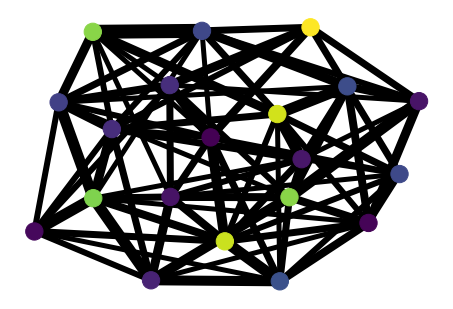

[ 6.  8.  7. 11.  6.  8.  7.  7. 10.]
[ 9.  5.  6.  5. 14.  5.  9.]
[9. 7. 6. 7. 7. 8.]
[ 6.  8.  7. 11.  8. 10.  6.  9.  5.]
[ 6.  9.  6.  7.  7.  7. 11. 11.  5.]
[ 8.  5.  9.  7. 11.  5.  5. 11. 11.]
[ 5.  9.  6.  5.  7.  6. 10.  8.]
[7. 8. 6. 5. 8. 9. 6. 5. 8.]
[11.  7.  8.  5.  6. 10.  5.  7.]
[ 7. 11.  5.  9.  6.  5.  8.]
[6. 6. 7. 9. 7. 7. 9. 6. 6. 6.]
[6. 7. 7. 6. 6. 5. 5. 6.]
[8. 5. 8. 7. 7. 5. 9. 6. 7.]
[10. 11.  5. 10.  7.  9.  6.]
[14.  7.  7.  5.  6.  6.  5.  9.  7.]
[ 7.  6. 11.  5.  5.  7.  5.  6.  6.  7.]
[ 7. 11.  6.  5.  6.  6.  6.]
[10.  5.  8. 10.  7.  6.  7.  5.  6.  6.  6.]
[ 9. 11.  8.  8.  9.  7.  5.]
[ 9.  5. 11.  8.  9.  7.  6.  6.  5.]
                        0          1
0    [17.727350755167564]  13.238957
1    [15.859326575161054]  10.872647
2     [19.26465904742651]  16.646363
3    [15.901117053967454]  13.978366
4     [17.94350025061847]  12.156108
5    [15.603874503510516]  11.039564
6     [2.773493752303742]   6.965519
7   [0.41013089019082294]   8.4892

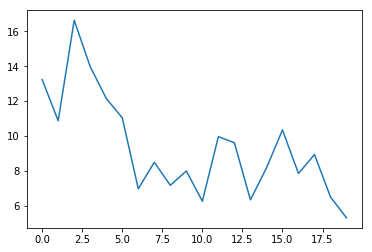

8.711604739575684 8.222264732643051
______NOOKS_________
DAY 27


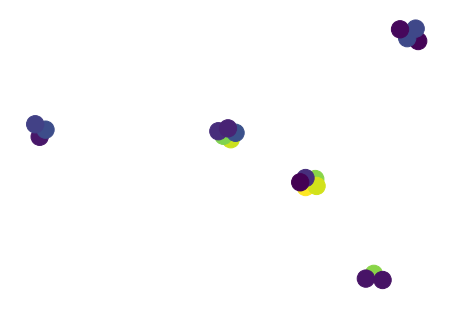

In [22]:

#print(sorted(member_vectors))
exp = NooksExperiment(member_vectors, alpha=2, swipe_mode="all")
exp.run(num_nooks=5)



______NETWORK_________


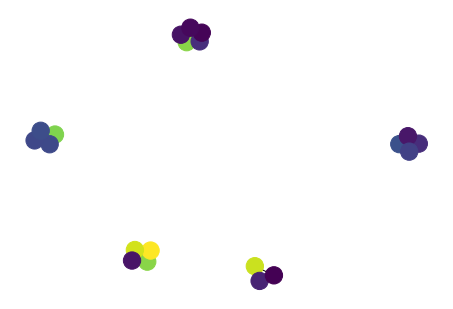

[1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1. 1.]
[1. 1.]
[1. 1. 1.]
[1. 1. 1.]
                        0          1
0    [17.727350755167564]  16.556315
1    [15.859326575161054]   6.695079
2     [19.26465904742651]   7.575851
3    [15.901117053967454]  14.630469
4     [17.94350025061847]   6.695079
5    [15.603874503510516]  11.123249
6     [2.773493752303742]   4.784752
7   [0.41013089019082294]   4.733263
8     [4.963525873735796]   2.298125
9    [1.2635963070241618]  16.425566
10    [2.664800067471699]   1.588942
11    [4.460695487448303]   3.814969
12   [1.2104681284607655]   4.393995
13     [2.08810369535688]   8.736691
14    [4.339727419191714]   3.895614
15    [1.431651205437282]   2.411041
16   [0.6884983184644466]   4.524488
17   [0.2539680116698967]   9.653759
18    [4.641454358071079]   3.814969
19   [3.8997507112121594]   1.5889

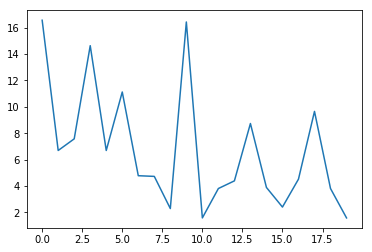

4.759007614236502 20.987912110863736
______NOOKS_________
DAY 0


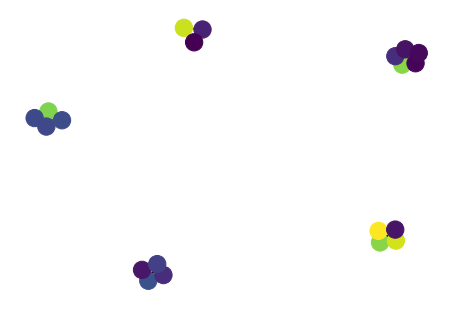

______NETWORK_________


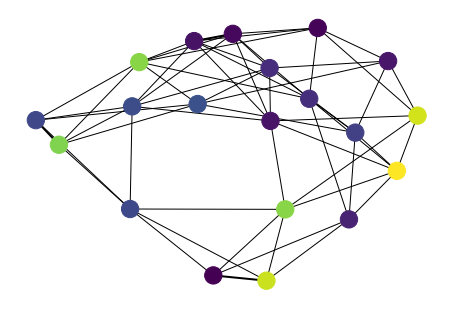

[1. 1. 1. 2.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 2. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 1.]
[1. 1. 1. 1. 1.]
[1. 2. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 1.]
[2. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
                        0          1
0    [17.727350755167564]  12.061827
1    [15.859326575161054]   9.417845
2     [19.26465904742651]  14.087805
3    [15.901117053967454]  14.016653
4     [17.94350025061847]  10.826091
5    [15.603874503510516]   8.861467
6     [2.773493752303742]   7.126035
7   [0.41013089019082294]   7.441915
8     [4.963525873735796]   5.694463
9    [1.2635963070241618]  10.811152
10    [2.664800067471699]   1.821444
11    [4.460695487448303]   8.039190
12   [1.2104681284607655]   4.332193
13     [2.08810369535688]   7.429395
14    [4.339727419191714]   4.774406
15    [1.43165

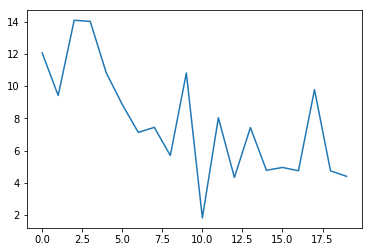

7.435655110820305 11.133514361303657
______NOOKS_________
DAY 1


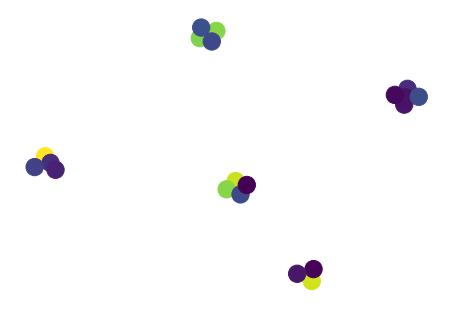

______NETWORK_________


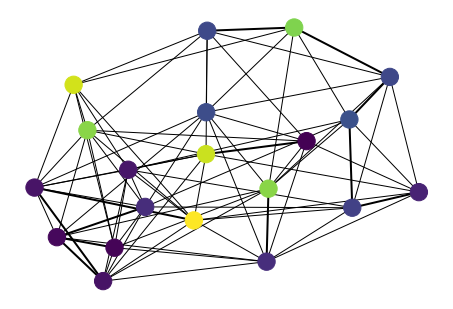

[1. 1. 1. 1. 1. 1. 1. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 2. 1. 1. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 2. 2. 1.]
[1. 2. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 2.]
[1. 1. 1. 1. 2. 1. 2.]
[1. 1. 2. 1. 1. 2. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 2. 1. 1.]
[1. 1. 1. 2. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 1. 2. 1.]
[1. 1. 1. 1. 1. 1. 2.]
[1. 2. 2. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 2. 1. 2. 2. 1.]
[2. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 2. 1. 2. 1. 1.]
                        0          1
0    [17.727350755167564]  16.477793
1    [15.859326575161054]  14.803128
2     [19.26465904742651]  17.511196
3    [15.901117053967454]  14.833805
4     [17.94350025061847]  13.309511
5    [15.603874503510516]   9.269944
6     [2.773493752303742]   7.317335
7   [0.41013089019082294]  10.223056
8     [4.963525873735796]   5.359478
9    [1.2635963070241618]  13.158716
10    [2.664800067471699]   4.340176
11    [4.460695487448303]  10.699600

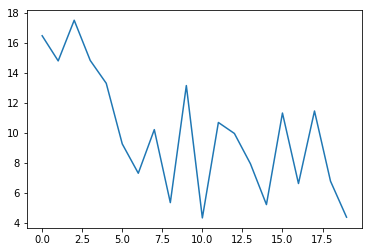

10.095210195930001 15.577582100621555
______NOOKS_________
DAY 2


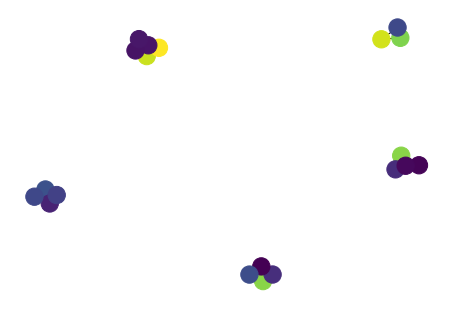

______NETWORK_________


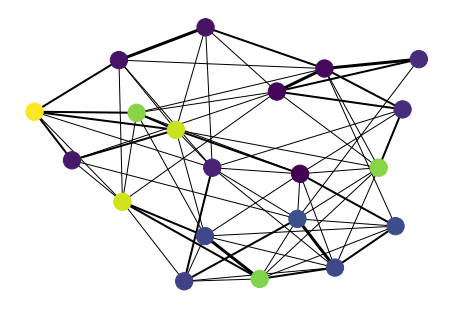

[2. 2. 1. 1. 1. 1. 1. 2. 2.]
[2. 2. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 1. 1.]
[1. 2. 1. 1. 1. 1. 1. 1.]
[1. 1. 2. 1. 1. 2. 1. 1.]
[2. 1. 1. 3. 2. 1. 1.]
[2. 2. 2. 1. 1.]
[1. 2. 1. 1. 2. 1. 1. 3.]
[1. 1. 1. 1. 3. 1. 1. 1. 2.]
[1. 2. 1. 3. 1. 1.]
[2. 1. 3.]
[1. 2. 3. 1. 1. 1. 1. 1.]
[1. 1. 3. 2. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 2.]
[2. 3. 1. 1. 1. 1. 2. 1.]
[2. 2. 1. 1. 1.]
[2. 3. 3. 2. 1. 1. 1. 1.]
[2. 1. 1. 1. 1. 1. 1. 1. 2.]
[1. 1. 1. 2. 1. 2.]
[1. 1. 2. 1. 2. 1.]
                        0          1
0    [17.727350755167564]  10.738259
1    [15.859326575161054]  10.299748
2     [19.26465904742651]  11.590653
3    [15.901117053967454]  14.207953
4     [17.94350025061847]  13.309511
5    [15.603874503510516]   9.482699
6     [2.773493752303742]   4.156179
7   [0.41013089019082294]   7.584151
8     [4.963525873735796]   5.595014
9    [1.2635963070241618]  10.404471
10    [2.664800067471699]   2.176566
11    [4.460695487448303]  10.699600
12   [1.2104681284607655]   3.753991
13     [2.088103695356

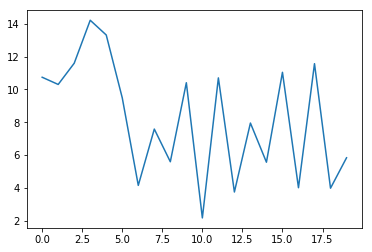

8.71679911151761 12.205280157933483
______NOOKS_________
DAY 3


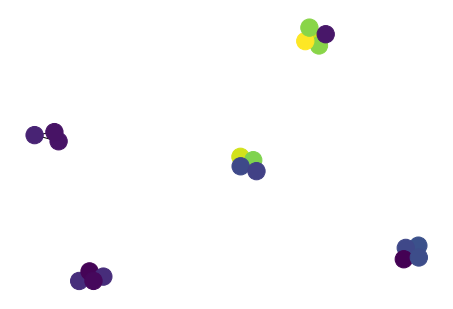

______NETWORK_________


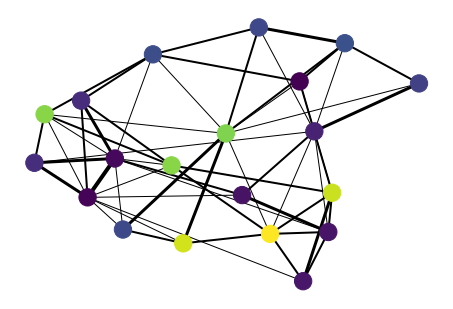

[2. 2. 2. 3. 2. 1.]
[2. 2. 2. 2. 1. 1.]
[2. 2. 2. 2. 2. 1. 1.]
[2. 2. 2. 1. 1. 1.]
[2. 3. 2. 1.]
[3. 1. 1. 2. 3. 2. 1. 1. 1.]
[2. 3. 3. 1.]
[3. 1. 1. 1. 2. 1. 1. 1. 4.]
[2. 3. 2. 2. 1.]
[2. 2. 3. 2. 1. 1.]
[2. 2. 3. 2.]
[2. 3. 1. 1.]
[1. 3. 2. 2.]
[2. 1. 1. 1. 1. 1. 1. 1. 3.]
[2. 3. 1. 2.]
[3. 2. 1. 2.]
[3. 4. 3. 2. 1. 1. 1. 1. 1.]
[2. 1. 2. 1. 2.]
[2. 1. 2. 2. 1. 2.]
[1. 2. 3.]
                        0          1
0    [17.727350755167564]  10.727634
1    [15.859326575161054]   6.791774
2     [19.26465904742651]   8.419574
3    [15.901117053967454]  11.026536
4     [17.94350025061847]   8.669240
5    [15.603874503510516]  10.147441
6     [2.773493752303742]   4.565343
7   [0.41013089019082294]   7.584151
8     [4.963525873735796]   3.982580
9    [1.2635963070241618]   7.102102
10    [2.664800067471699]   4.850538
11    [4.460695487448303]   8.112186
12   [1.2104681284607655]   0.563268
13     [2.08810369535688]   7.676101
14    [4.339727419191714]   3.610324
15    [1.431651205437282] 

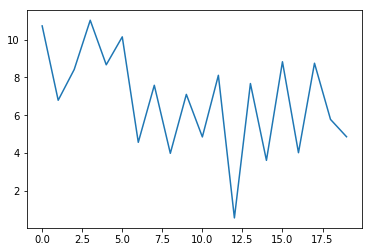

7.343126264572668 7.005115029521626
______NOOKS_________
DAY 4


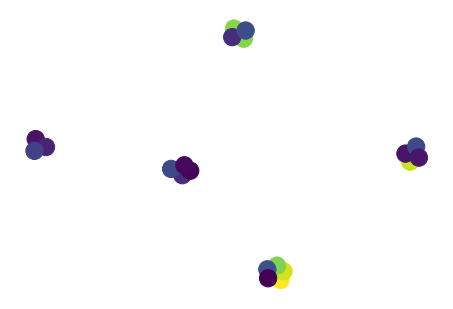

______NETWORK_________


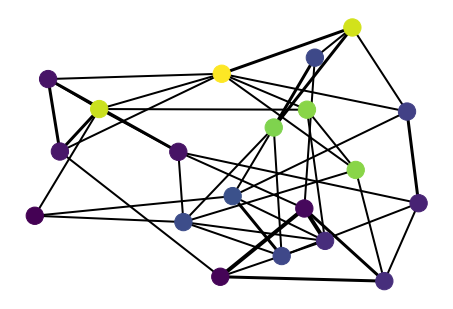

[2. 2. 2. 2. 3. 2.]
[2. 2. 2. 2.]
[2. 2. 2. 3. 2. 2. 2.]
[2. 2. 2. 2.]
[3. 3. 2. 2.]
[3. 2. 3. 2. 2.]
[2. 3. 2. 3.]
[3. 2. 2. 4.]
[2. 2. 3. 2. 2.]
[2. 2. 3. 3.]
[2. 2. 2. 4. 2.]
[2. 3. 2.]
[2. 3. 2. 2. 2.]
[2. 2. 2. 3.]
[2. 3. 2. 2.]
[3. 2. 2. 3.]
[3. 4. 4. 2. 2.]
[2. 2. 2.]
[2. 2. 2. 2. 2. 2.]
[2. 2. 2. 3.]
                        0          1
0    [17.727350755167564]  13.723549
1    [15.859326575161054]   4.627418
2     [19.26465904742651]  11.185094
3    [15.901117053967454]   6.948155
4     [17.94350025061847]   7.796835
5    [15.603874503510516]   9.269944
6     [2.773493752303742]   4.565343
7   [0.41013089019082294]   1.479480
8     [4.963525873735796]   3.867241
9    [1.2635963070241618]   8.671500
10    [2.664800067471699]   4.340176
11    [4.460695487448303]   9.466060
12   [1.2104681284607655]   4.280120
13     [2.08810369535688]   1.406574
14    [4.339727419191714]   3.610324
15    [1.431651205437282]   8.829571
16   [0.6884983184644466]   1.726766
17   [0.2539680116698967

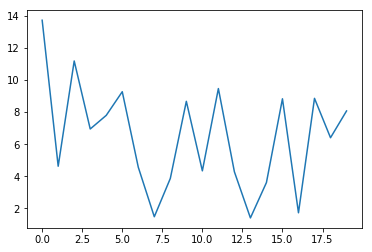

6.675798279522861 10.833735719864181
______NOOKS_________
DAY 5


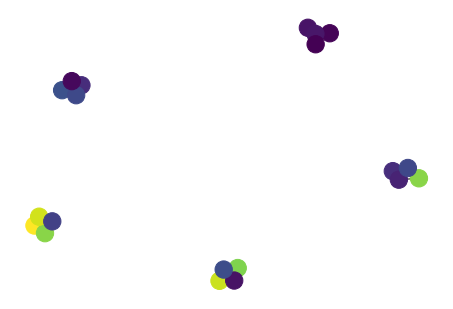

______NETWORK_________


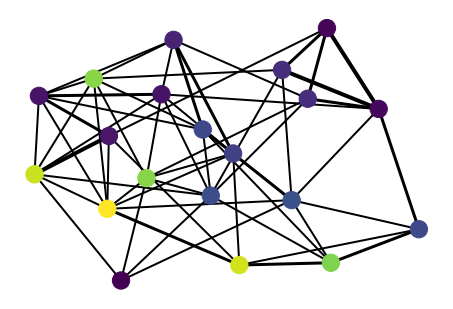

[2. 2. 2. 2. 4. 2. 2.]
[2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 3. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2.]
[3. 3. 2. 2. 2.]
[3. 2. 3. 2. 2.]
[2. 3. 2. 3. 2.]
[3. 3. 2. 4.]
[2. 2. 2. 2. 3. 2. 2. 2.]
[2. 2. 2. 3. 2. 2. 3.]
[2. 3. 2. 4. 2.]
[2. 3. 2. 3.]
[2. 2. 3. 2. 2. 2. 2.]
[2. 2. 2. 2. 3. 3.]
[2. 2. 3. 2. 3. 2.]
[4. 2. 2. 2. 3.]
[3. 4. 2. 4. 3. 2.]
[2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 3.]
                        0          1
0    [17.727350755167564]  15.967123
1    [15.859326575161054]  11.297282
2     [19.26465904742651]  13.364254
3    [15.901117053967454]  13.345290
4     [17.94350025061847]   9.539838
5    [15.603874503510516]   9.269944
6     [2.773493752303742]   4.025866
7   [0.41013089019082294]   1.479480
8     [4.963525873735796]   6.909973
9    [1.2635963070241618]   9.856346
10    [2.664800067471699]   4.340176
11    [4.460695487448303]   7.225253
12   [1.2104681284607655]   7.476186
13     [2.08810369535688]   3.907327
14    [4.339727419191714]   5.747060
15    [1

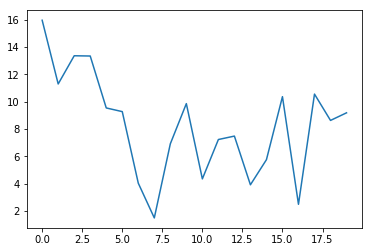

8.903740563142641 13.89502802330783
______NOOKS_________
DAY 6


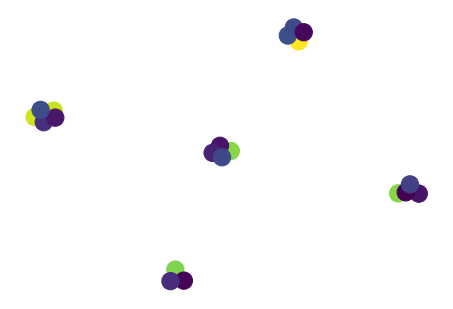

______NETWORK_________


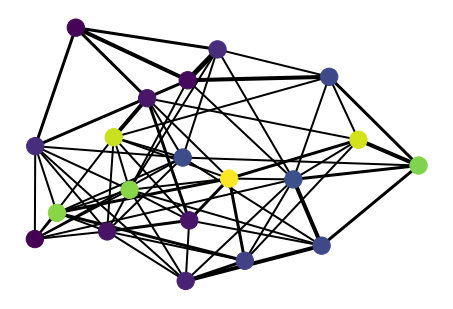

[2. 2. 2. 2. 2. 4. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 3. 3. 2. 3. 2. 3.]
[2. 3. 2. 2. 2. 2. 3.]
[3. 4. 2. 2. 2. 2.]
[4. 3. 3. 3. 2.]
[2. 2. 3. 2. 2. 3. 2. 2.]
[3. 3. 3. 4.]
[2. 2. 3. 4. 2. 2. 2. 2. 2. 2.]
[2. 2. 3. 3. 2. 2. 3.]
[2. 3. 2. 2. 5. 2.]
[2. 2. 3. 2. 2. 4.]
[2. 2. 2. 3. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 4. 3.]
[2. 3. 4. 2. 4. 2.]
[4. 2. 2. 3. 3. 2.]
[3. 4. 5. 4. 2. 2.]
[2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2.]
[3. 3. 2. 2. 3. 2.]
                        0          1
0    [17.727350755167564]  16.003275
1    [15.859326575161054]  14.050534
2     [19.26465904742651]  11.176736
3    [15.901117053967454]  11.766066
4     [17.94350025061847]   9.539838
5    [15.603874503510516]   9.269944
6     [2.773493752303742]   6.636268
7   [0.41013089019082294]   1.479480
8     [4.963525873735796]   8.650962
9    [1.2635963070241618]   9.856346
10    [2.664800067471699]   4.340176
11    [4.460695487448303]   8.692146
12   [1.2104681284607655]   7.476186
13     [2.088103695356

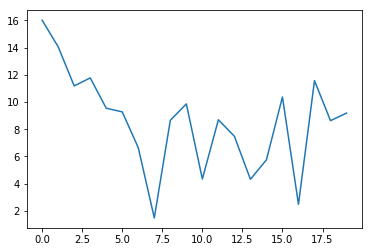

8.937168545289472 12.712559568559136
______NOOKS_________
DAY 7


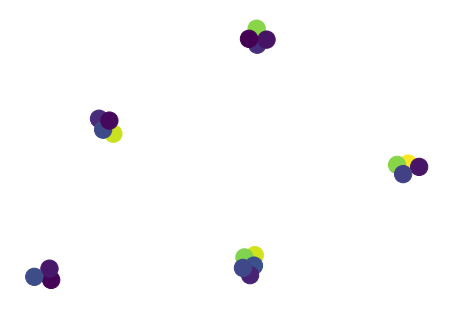

______NETWORK_________


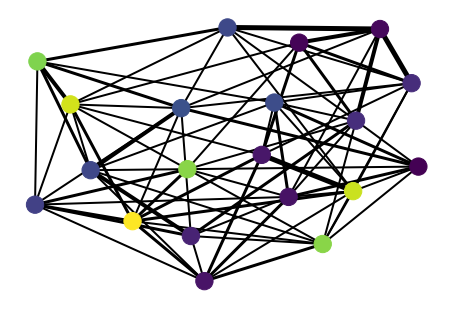

[2. 3. 2. 2. 2. 2. 5. 2. 2.]
[2. 2. 2. 2. 3. 2. 2. 2. 2.]
[3. 2. 3. 3. 2. 3. 3. 3.]
[2. 3. 3. 2. 2. 2. 2. 2. 2.]
[3. 2. 4. 2. 2. 2. 2. 2. 2.]
[4. 3. 3. 3. 2. 2.]
[2. 2. 3. 2. 2. 3. 4. 2. 2.]
[2. 3. 2. 3. 3. 4.]
[2. 2. 3. 4. 3. 2. 2. 2. 2. 2.]
[2. 3. 3. 3. 2. 2. 3. 2.]
[2. 2. 3. 2. 2. 2. 5. 2.]
[2. 2. 3. 2. 2. 2. 5.]
[2. 2. 3. 2. 2. 2. 3. 3. 2.]
[2. 3. 2. 2. 2. 4. 3.]
[2. 2. 3. 4. 2. 4. 2. 2.]
[5. 3. 2. 3. 3. 2. 2.]
[4. 4. 5. 5. 2. 2.]
[2. 2. 2. 3. 3. 2. 3.]
[2. 2. 2. 2. 3. 2. 2. 3.]
[3. 3. 2. 2. 2. 2. 3. 2.]
                        0          1
0    [17.727350755167564]  13.657406
1    [15.859326575161054]  14.050534
2     [19.26465904742651]  11.219966
3    [15.901117053967454]  12.238738
4     [17.94350025061847]  10.349950
5    [15.603874503510516]   9.418285
6     [2.773493752303742]   6.269441
7   [0.41013089019082294]   4.690258
8     [4.963525873735796]   8.650962
9    [1.2635963070241618]   9.856346
10    [2.664800067471699]   6.957355
11    [4.460695487448303]   8.692146
12   

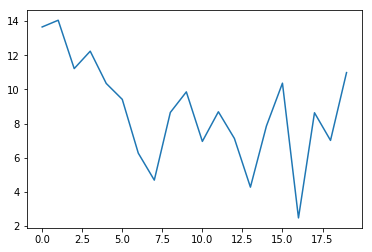

8.67155441328702 8.696056947812759
______NOOKS_________
DAY 8


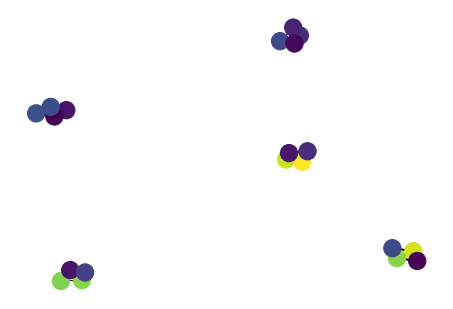

______NETWORK_________


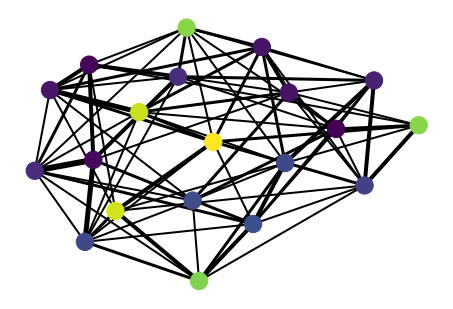

[3. 3. 3. 5. 2. 2. 2. 2.]
[3. 3. 2. 2. 2. 2. 2. 2. 2.]
[3. 2. 3. 4. 2. 3. 2. 3. 3.]
[3. 3. 4. 2. 2. 2.]
[4. 4. 3. 2. 2. 2. 2.]
[4. 4. 2. 3. 3. 2. 2.]
[3. 4. 3. 4. 2. 2. 2. 2.]
[4. 2. 2. 2. 3. 4. 4.]
[2. 4. 3. 4. 3. 3. 2. 2. 2.]
[3. 3. 3. 4. 2. 3. 3. 2.]
[2. 3. 3. 2. 2. 2. 2. 6. 2.]
[2. 3. 3. 2. 2. 2. 2. 5. 2.]
[3. 4. 2. 2. 2. 2. 3. 3. 2.]
[3. 2. 2. 2. 2. 4. 2. 4.]
[3. 4. 3. 4. 2. 2. 2. 2. 2.]
[5. 3. 4. 3. 2. 2. 2. 2. 2.]
[4. 4. 3. 6. 5. 2.]
[3. 3. 3. 2. 2. 2. 2. 3. 2.]
[2. 2. 2. 3. 2. 2. 3.]
[3. 4. 2. 2. 2. 4. 2. 2. 2.]
                        0          1
0    [17.727350755167564]  13.657406
1    [15.859326575161054]  14.632759
2     [19.26465904742651]  11.176736
3    [15.901117053967454]  12.238738
4     [17.94350025061847]  10.237762
5    [15.603874503510516]   9.665275
6     [2.773493752303742]   4.147821
7   [0.41013089019082294]   4.690258
8     [4.963525873735796]   4.509492
9    [1.2635963070241618]  10.437961
10    [2.664800067471699]   6.957355
11    [4.460695487448303]  11.

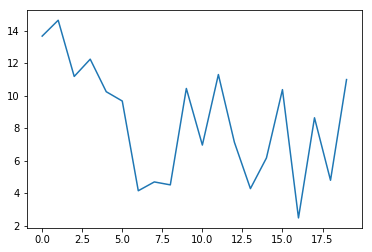

9.15004510243557 11.888625591885633
______NOOKS_________
DAY 9


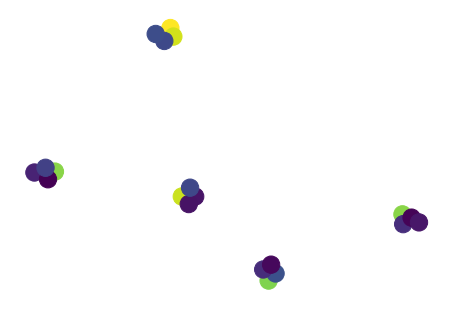

______NETWORK_________


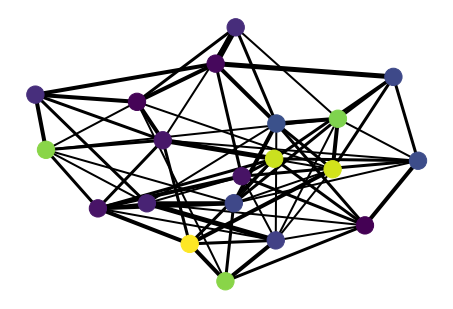

[3. 3. 3. 3. 5. 3. 3. 2.]
[4. 3. 3. 2. 2. 2. 2.]
[3. 4. 4. 4. 3. 3.]
[4. 3. 3. 4. 2.]
[4. 4. 3. 3. 2. 2. 2. 2.]
[4. 2. 4. 2. 3. 3. 2. 2.]
[4. 4. 3. 3. 4.]
[4. 2. 2. 2. 3. 4. 4.]
[3. 4. 3. 4. 4. 3. 2. 2.]
[3. 3. 4. 4. 4. 3. 2. 2.]
[2. 3. 3. 6. 2.]
[3. 3. 3. 5. 3.]
[3. 4. 3. 3. 3. 2. 2.]
[3. 2. 2. 2. 2. 4. 2. 5.]
[3. 3. 4. 4. 4. 2. 2. 2. 2.]
[5. 3. 3. 3. 4. 3. 2. 2. 2.]
[4. 4. 4. 6. 5. 3.]
[3. 3. 3. 3. 2. 4. 2.]
[3. 2. 3. 3. 2. 2. 4.]
[3. 4. 2. 5. 2. 2. 2. 2. 2.]
                        0          1
0    [17.727350755167564]  16.003275
1    [15.859326575161054]  14.265931
2     [19.26465904742651]  11.176736
3    [15.901117053967454]  11.612887
4     [17.94350025061847]   9.531387
5    [15.603874503510516]   9.665275
6     [2.773493752303742]   3.912285
7   [0.41013089019082294]   4.690258
8     [4.963525873735796]   6.645741
9    [1.2635963070241618]  10.437961
10    [2.664800067471699]   4.140384
11    [4.460695487448303]   8.369119
12   [1.2104681284607655]   4.295893
13     [2.088103

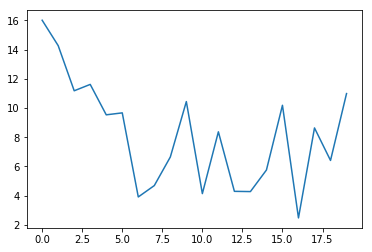

8.501967119761144 13.058271293331464
______NOOKS_________
DAY 10


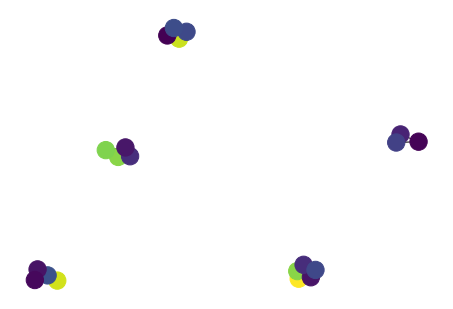

______NETWORK_________


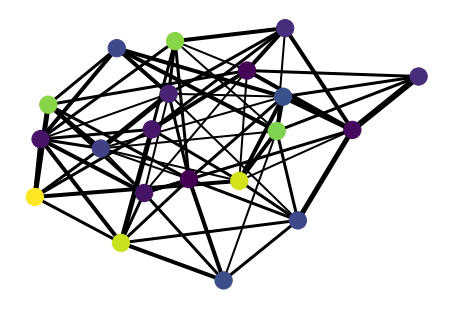

[3. 4. 3. 3. 5. 3. 4.]
[4. 3. 3. 3. 3. 2. 2.]
[3. 5. 4. 4. 3. 3.]
[5. 3. 3. 3. 3. 4.]
[4. 4. 4. 3. 3. 2. 2. 2.]
[4. 2. 2. 4. 3. 3. 4. 2. 2.]
[4. 2. 4. 3. 3. 4.]
[3. 4. 2. 2. 3. 2. 4. 4.]
[4. 4. 3. 4. 5. 3. 2. 2.]
[4. 3. 4. 4. 4. 3. 3. 2.]
[3. 3. 3. 6.]
[3. 3. 3. 5. 3. 3. 2.]
[3. 3. 2. 4. 3. 3. 3. 2. 2.]
[3. 3. 2. 2. 2. 2. 4. 3. 5.]
[3. 4. 4. 4. 4.]
[5. 3. 3. 3. 3. 4. 3.]
[4. 4. 5. 6. 5. 3. 2.]
[3. 3. 3. 3. 3. 3. 3. 4. 2.]
[4. 2. 3. 3. 4.]
[3. 4. 2. 3. 5. 2. 2. 2. 2.]
                        0          1
0    [17.727350755167564]  15.967123
1    [15.859326575161054]  14.297164
2     [19.26465904742651]  11.176736
3    [15.901117053967454]  12.238738
4     [17.94350025061847]   9.327083
5    [15.603874503510516]   9.665275
6     [2.773493752303742]   3.912285
7   [0.41013089019082294]   4.281781
8     [4.963525873735796]   6.645741
9    [1.2635963070241618]  10.437961
10    [2.664800067471699]   4.867193
11    [4.460695487448303]   9.174313
12   [1.2104681284607655]   7.129629
13     [2.

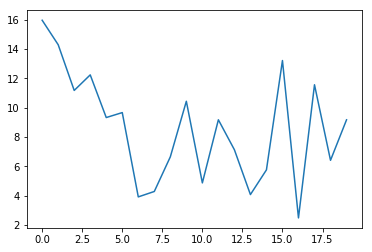

9.172938933013313 13.692445944285634
______NOOKS_________
DAY 11


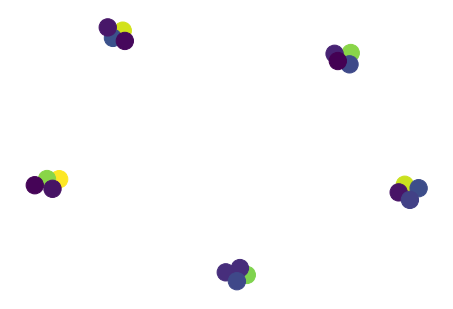

______NETWORK_________


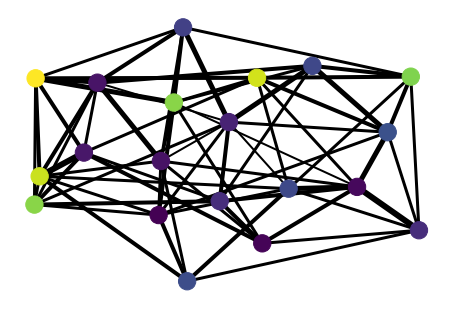

[3. 4. 4. 3. 3. 6. 3. 4.]
[3. 3. 4. 3. 3. 4. 3.]
[4. 3. 5. 4. 4. 4. 3.]
[5. 3. 3. 3. 3. 4. 4. 2.]
[4. 3. 4. 4. 3. 3. 3.]
[4. 4. 3. 3. 4. 3.]
[4. 4. 4. 3. 3. 4.]
[3. 4. 3. 3. 4. 4.]
[4. 4. 3. 3. 5. 5. 3.]
[4. 3. 4. 5. 4. 3. 4. 2.]
[3. 3. 3. 3. 6. 3.]
[3. 3. 3. 3. 5. 3. 4. 2.]
[3. 3. 3. 5. 3. 3. 3. 3. 2.]
[3. 4. 3. 2. 2. 2. 5. 3. 5.]
[3. 4. 3. 5. 4. 5.]
[6. 4. 4. 3. 3. 4. 3.]
[3. 4. 4. 5. 6. 5. 3. 2.]
[3. 3. 4. 3. 3. 3. 3. 4.]
[4. 3. 4. 3. 4.]
[3. 4. 3. 4. 3. 5.]
                        0          1
0    [17.727350755167564]  12.971208
1    [15.859326575161054]  14.297164
2     [19.26465904742651]   8.411216
3    [15.901117053967454]  12.238738
4     [17.94350025061847]  10.081522
5    [15.603874503510516]   9.777464
6     [2.773493752303742]   3.957163
7   [0.41013089019082294]   4.281781
8     [4.963525873735796]   6.645741
9    [1.2635963070241618]   8.046046
10    [2.664800067471699]   4.289085
11    [4.460695487448303]   8.369119
12   [1.2104681284607655]   7.476186
13     [2.088103

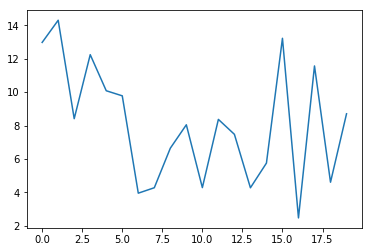

8.207582597002297 11.86822590840715
______NOOKS_________
DAY 12


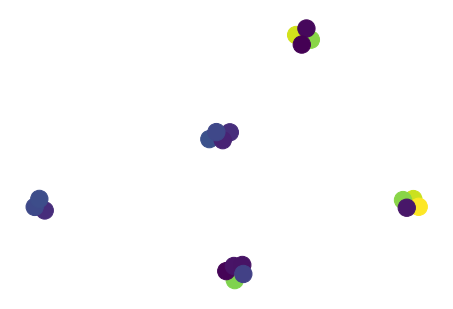

______NETWORK_________


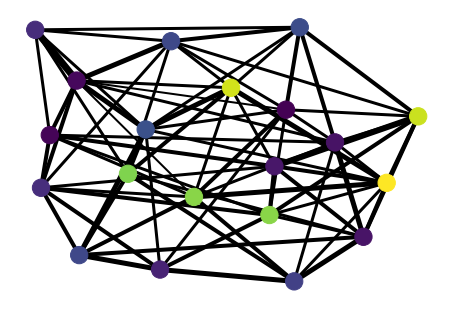

[4. 4. 4. 3. 3. 6. 3. 4.]
[4. 3. 4. 3. 3. 4. 4. 3.]
[4. 3. 5. 5. 3. 4. 3. 4. 3.]
[5. 3. 3. 3. 3. 4. 4. 4. 2.]
[5. 3. 4. 5. 3. 3. 3. 3.]
[4. 4. 3. 3. 3. 4. 4.]
[4. 3. 4. 3. 4. 4. 3. 4.]
[3. 3. 4. 3. 3. 4. 4.]
[3. 5. 4. 5. 5. 3. 3. 3. 3.]
[4. 3. 4. 3. 5. 4. 4. 5.]
[3. 3. 3. 3. 7. 3.]
[3. 3. 3. 3. 3. 5. 3. 4.]
[3. 3. 3. 3. 5. 4. 3. 3. 3.]
[4. 4. 3. 5. 3. 5.]
[4. 4. 4. 5. 4. 5.]
[6. 4. 4. 3. 3. 4. 4.]
[3. 4. 4. 5. 7. 5. 2. 3. 2.]
[3. 3. 4. 3. 3. 2. 3. 3. 4.]
[4. 3. 3. 4. 4. 4. 3.]
[3. 4. 4. 5. 5. 3.]
                        0          1
0    [17.727350755167564]   9.850137
1    [15.859326575161054]  11.751623
2     [19.26465904742651]   8.411216
3    [15.901117053967454]  11.612887
4     [17.94350025061847]  10.081522
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   3.957163
7   [0.41013089019082294]   6.920686
8     [4.963525873735796]   8.564056
9    [1.2635963070241618]   8.046046
10    [2.664800067471699]   4.289085
11    [4.460695487448303]   8.369119
12   [1.210468128

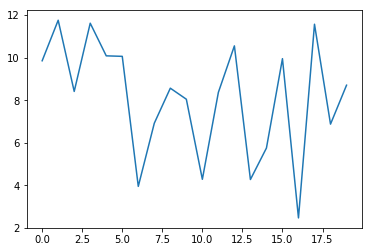

8.487636185508114 7.247593007256739
______NOOKS_________
DAY 13


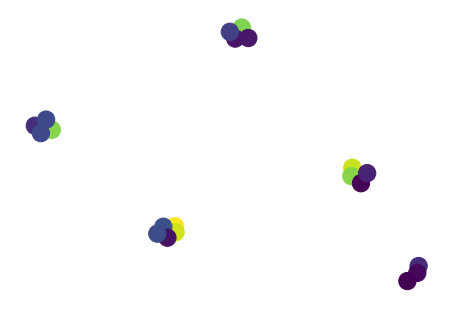

______NETWORK_________


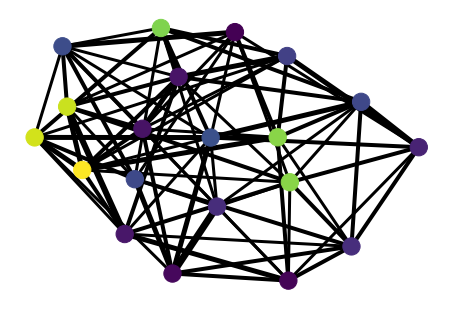

[4. 5. 4. 3. 4. 6. 3. 4.]
[4. 4. 4. 4. 3. 3. 3. 3. 3. 3.]
[5. 3. 5. 5. 3. 4. 4. 4. 3.]
[5. 3. 3. 4. 3. 4. 4. 4.]
[5. 3. 4. 5. 4. 3. 3. 3. 3.]
[4. 4. 4. 3. 3. 4. 3. 4.]
[4. 3. 4. 4. 4. 4. 3. 4.]
[4. 4. 3. 3. 3. 3. 5. 4.]
[3. 5. 4. 4. 5. 5. 3. 3. 3. 3.]
[4. 4. 4. 3. 5. 4. 4. 3. 5.]
[3. 3. 3. 3. 3. 3. 7. 3.]
[3. 4. 3. 4. 3. 5. 3. 4.]
[4. 4. 3. 3. 5. 4. 4. 3. 3.]
[4. 4. 3. 4. 5. 3. 5.]
[4. 4. 4. 5. 4. 3. 5. 3.]
[6. 4. 4. 3. 3. 5. 4. 3.]
[3. 4. 4. 5. 7. 5. 4.]
[3. 4. 3. 3. 3. 3. 3. 5.]
[4. 3. 3. 3. 3. 4. 4. 5. 3.]
[3. 4. 3. 4. 5. 5. 3.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  11.751623
2     [19.26465904742651]   8.455453
3    [15.901117053967454]  11.612887
4     [17.94350025061847]   9.475713
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   4.157525
7   [0.41013089019082294]   6.920686
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]  10.298876
10    [2.664800067471699]   6.532660
11    [4.460695487

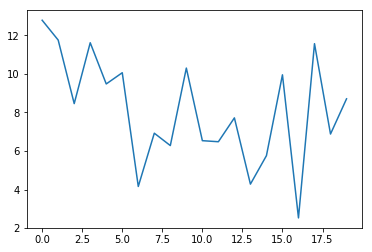

8.085442050573672 7.609707910549884
______NOOKS_________
DAY 14


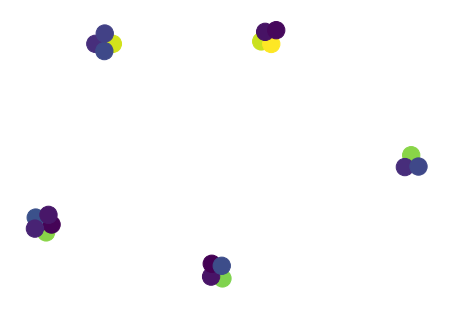

______NETWORK_________


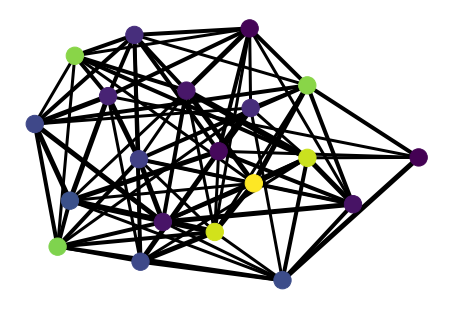

[4. 5. 4. 3. 3. 5. 6. 3. 4.]
[4. 4. 4. 4. 3. 3. 3. 3.]
[5. 3. 5. 5. 3. 4. 4. 5. 4.]
[5. 3. 3. 4. 3. 4. 4. 4. 4.]
[5. 3. 4. 6. 5. 3. 3. 3. 3. 3.]
[4. 3. 4. 4. 3. 3. 4. 4. 4.]
[4. 3. 4. 4. 4. 4. 4. 4. 3.]
[4. 4. 3. 3. 3. 3. 4. 5. 4.]
[3. 6. 4. 5. 5. 5. 3. 3.]
[4. 4. 4. 5. 5. 4. 5. 3.]
[3. 3. 3. 3. 7. 3. 3.]
[3. 5. 3. 4. 5. 4. 3.]
[5. 4. 4. 3. 5. 4. 4. 3.]
[4. 4. 4. 5. 3. 5. 3. 5.]
[4. 4. 4. 5. 5. 5. 3. 3.]
[6. 4. 5. 4. 5. 4. 3. 3. 3.]
[4. 4. 5. 7. 5. 4. 3. 3.]
[3. 4. 3. 3. 5.]
[4. 4. 4. 4. 5. 3. 3. 3. 3.]
[4. 4. 4. 3. 5. 5. 3. 3. 3.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  11.720390
2     [19.26465904742651]   8.421842
3    [15.901117053967454]  12.238738
4     [17.94350025061847]   9.531387
5    [15.603874503510516]  11.782264
6     [2.773493752303742]   4.157525
7   [0.41013089019082294]   4.166442
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]   8.046046
10    [2.664800067471699]   9.093783
11    [4.460695487

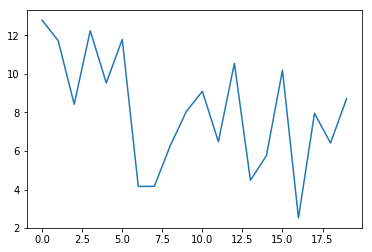

8.23394387269457 8.452372755941237
______NOOKS_________
DAY 15


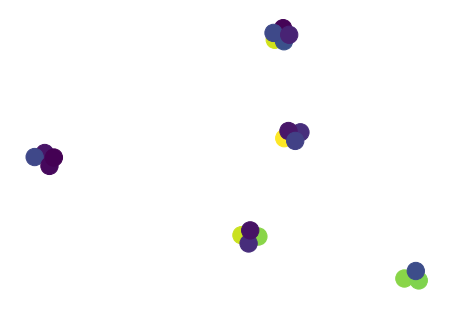

______NETWORK_________


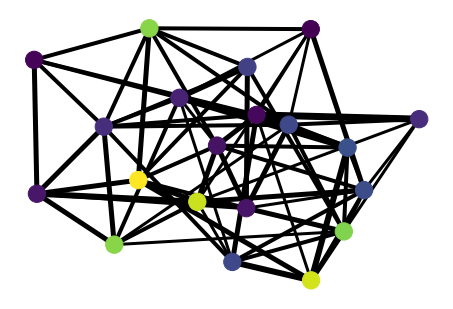

[4. 5. 4. 3. 3. 5. 6. 3. 5.]
[4. 5. 4. 5. 3. 3.]
[5. 5. 5. 4. 4. 5. 4.]
[5. 4. 4. 4. 4. 4. 4.]
[5. 5. 6. 6. 3. 3.]
[5. 3. 4. 5. 3. 4. 4. 4. 4.]
[5. 4. 4. 4. 4. 4. 5. 4. 3.]
[4. 4. 4. 5. 4.]
[6. 4. 4. 6. 5. 6. 3.]
[4. 4. 5. 5. 5. 4. 5. 3.]
[3. 3. 4. 7. 3.]
[3. 6. 4. 4. 5. 4. 3.]
[5. 4. 4. 4. 5. 5. 4. 3.]
[4. 4. 4. 6. 3. 3. 5. 3. 5.]
[4. 4. 4. 5. 5. 4. 5. 3. 3.]
[6. 5. 5. 5. 5. 4.]
[4. 4. 6. 7. 5. 5. 3. 3.]
[3. 4. 3. 3. 3. 5.]
[5. 4. 4. 4. 5. 3. 3. 3. 3.]
[4. 4. 4. 3. 5. 5.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  10.934471
2     [19.26465904742651]   8.421842
3    [15.901117053967454]  12.463990
4     [17.94350025061847]   9.475713
5    [15.603874503510516]  10.158271
6     [2.773493752303742]   6.400731
7   [0.41013089019082294]   4.166442
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]   7.621351
10    [2.664800067471699]   6.725902
11    [4.460695487448303]   6.053228
12   [1.2104681284607655]   9.967364
13  

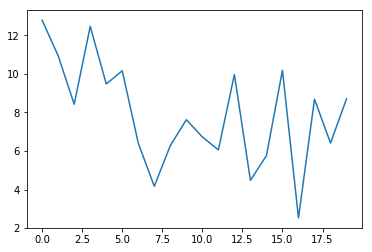

8.021596247528866 7.177628862971122
______NOOKS_________
DAY 16


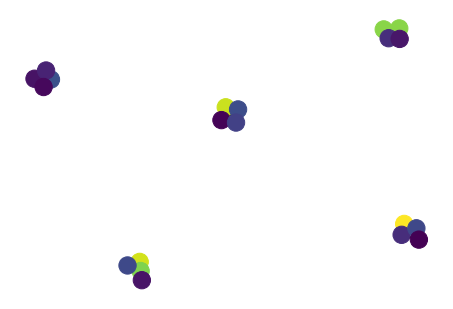

______NETWORK_________


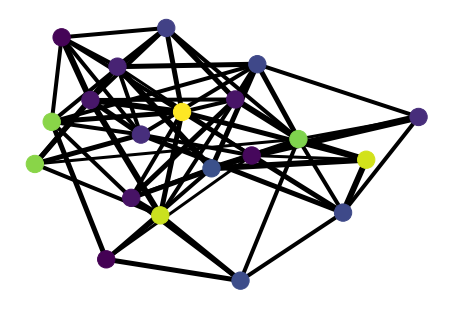

[4. 5. 4. 5. 6. 4. 5.]
[4. 5. 5. 5. 3.]
[5. 5. 5. 4. 4. 6. 5.]
[5. 4. 4. 4. 4. 5. 4.]
[5. 6. 6. 6. 3.]
[6. 3. 4. 6. 3. 4. 5. 4. 4.]
[5. 4. 4. 5. 4. 4. 5. 4.]
[4. 4. 4. 6. 4. 4.]
[6. 4. 4. 6. 5. 6. 4.]
[4. 4. 6. 5. 6. 4. 5.]
[3. 4. 4. 7.]
[6. 4. 5. 4. 5. 4.]
[5. 4. 4. 4. 5. 5. 4.]
[5. 4. 4. 6. 5. 5. 3.]
[4. 5. 4. 5. 6. 4. 5.]
[6. 5. 6. 5. 6. 4. 4.]
[4. 4. 6. 7. 5. 5. 3. 3. 3.]
[4. 5. 4. 3. 5.]
[5. 4. 4. 4. 5.]
[5. 4. 4. 4. 5. 5. 4.]
                        0          1
0    [17.727350755167564]  12.981834
1    [15.859326575161054]   8.681641
2     [19.26465904742651]   7.883985
3    [15.901117053967454]  12.463990
4     [17.94350025061847]   9.475713
5    [15.603874503510516]  10.158271
6     [2.773493752303742]   6.321173
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]   7.621351
10    [2.664800067471699]   4.596550
11    [4.460695487448303]   6.376256
12   [1.2104681284607655]   9.967364
13     [2.08810369535688]   4.477578
14    [4.

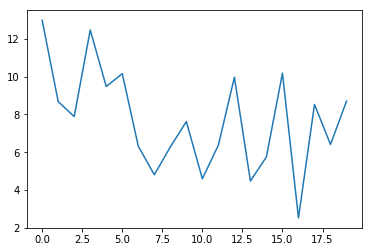

7.752667989253725 7.003155326175284
______NOOKS_________
DAY 17


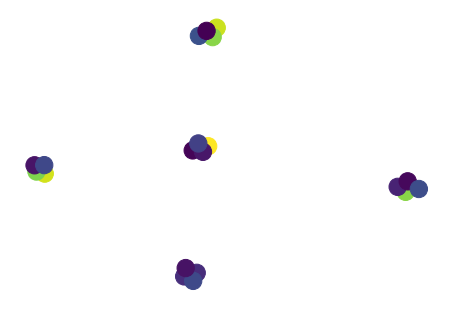

______NETWORK_________


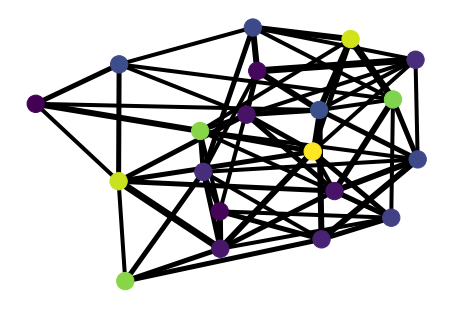

[4. 5. 5. 5. 7. 4. 5.]
[4. 5. 5. 5.]
[5. 5. 5. 4. 4. 4. 5. 6. 5.]
[5. 4. 5. 4. 4. 4. 6. 4.]
[5. 4. 7. 6. 6.]
[7. 4. 6. 4. 5. 4. 4.]
[5. 5. 4. 5. 4. 4. 5. 4.]
[4. 4. 5. 6. 4. 4.]
[4. 6. 4. 4. 5. 6. 5. 6. 4.]
[5. 4. 6. 5. 6. 5. 5.]
[4. 4. 4. 4. 4. 7.]
[6. 4. 5. 4. 6. 4.]
[5. 5. 4. 5. 5. 4. 5. 4.]
[5. 4. 5. 6. 6. 5.]
[4. 5. 4. 5. 6. 4. 6.]
[7. 5. 6. 5. 6. 5. 4.]
[4. 4. 6. 7. 6. 5.]
[4. 6. 4. 5.]
[5. 4. 4. 4. 5.]
[5. 4. 4. 4. 5. 5. 4.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  10.788189
2     [19.26465904742651]  11.230591
3    [15.901117053967454]  12.463990
4     [17.94350025061847]   6.433189
5    [15.603874503510516]  10.158271
6     [2.773493752303742]   6.321173
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   4.901456
9    [1.2635963070241618]   7.336875
10    [2.664800067471699]   4.869142
11    [4.460695487448303]   6.376256
12   [1.2104681284607655]   7.779846
13     [2.08810369535688]   4.477578
14    [4.

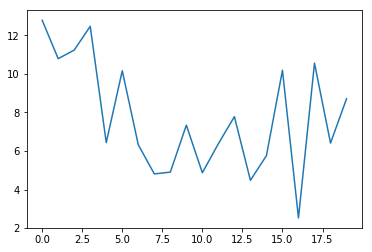

6.885031994001827 8.201799544671974
______NOOKS_________
DAY 18


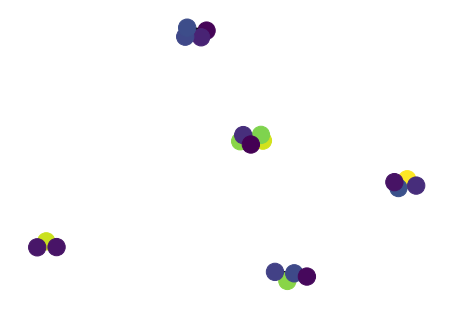

______NETWORK_________


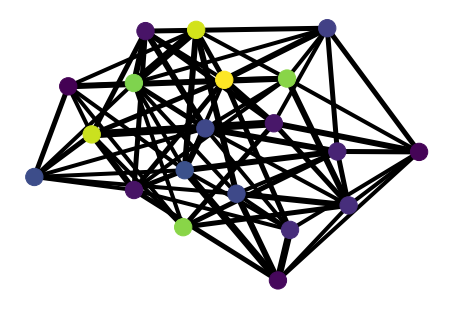

[4. 5. 5. 6. 8. 4. 5.]
[4. 4. 5. 5. 5. 4.]
[5. 5. 5. 4. 4. 5. 5. 6. 6.]
[5. 4. 6. 4. 4. 4. 6. 4.]
[5. 4. 8. 6. 6. 4.]
[4. 8. 4. 6. 4. 5. 4. 4. 4.]
[5. 6. 4. 6. 5. 4. 5. 4.]
[4. 4. 4. 5. 6. 4. 5.]
[4. 6. 4. 5. 6. 6. 7. 4. 4. 4.]
[5. 4. 6. 5. 6. 5. 5.]
[5. 4. 4. 4. 4. 4. 7.]
[6. 4. 6. 4. 4. 6. 4.]
[6. 5. 4. 5. 5. 4. 5. 4.]
[5. 5. 5. 6. 4. 6. 5.]
[4. 5. 4. 6. 6. 4. 6. 4.]
[8. 5. 6. 5. 6. 5. 4.]
[4. 4. 7. 7. 6. 5.]
[4. 4. 6. 4. 4. 4. 5.]
[5. 4. 4. 4. 4. 5. 4.]
[6. 4. 4. 5. 5. 5. 4.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  11.751623
2     [19.26465904742651]  14.243102
3    [15.901117053967454]  12.463990
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.999616
6     [2.773493752303742]   5.985578
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   4.901456
9    [1.2635963070241618]   7.336875
10    [2.664800067471699]   4.985090
11    [4.460695487448303]   6.491595
12   [1.2104681284607655]   7.77984

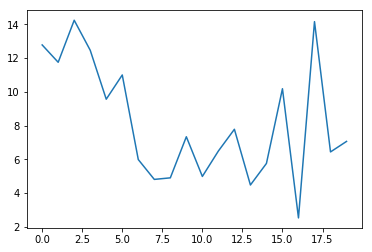

7.198806897943268 11.765762656115836
______NOOKS_________
DAY 19


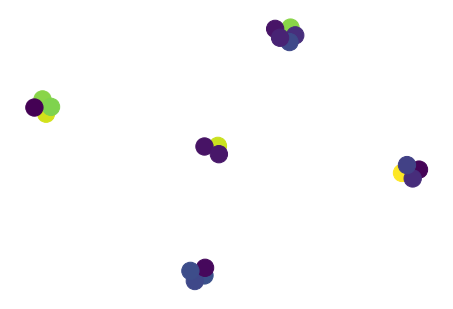

______NETWORK_________


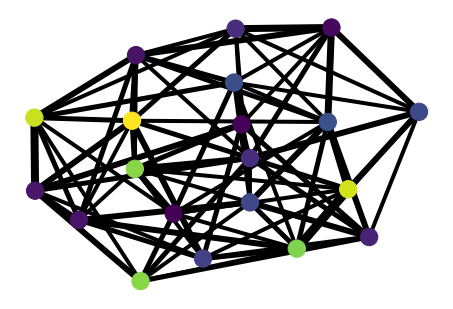

[4. 5. 5. 4. 6. 8. 4. 5.]
[4. 4. 5. 5. 4. 6. 5.]
[5. 5. 5. 4. 4. 5. 6. 6. 6.]
[5. 4. 6. 5. 4. 4. 4. 6. 4.]
[5. 4. 9. 7. 6. 4. 4.]
[4. 9. 5. 6. 4. 5. 4. 4. 5.]
[5. 6. 4. 6. 4. 5. 4. 5. 5.]
[5. 4. 4. 5. 6. 4. 5.]
[4. 7. 5. 5. 6. 6. 7. 4. 4. 4.]
[5. 4. 4. 6. 5. 6. 5. 5.]
[4. 5. 4. 4. 4. 4. 4. 7.]
[6. 4. 6. 4. 4. 6. 4.]
[6. 6. 4. 4. 5. 5. 4. 6. 5.]
[5. 5. 5. 6. 4. 6. 5.]
[4. 4. 5. 4. 6. 6. 4. 6. 4. 4.]
[8. 6. 6. 5. 6. 5. 4.]
[5. 4. 7. 7. 6. 6. 4.]
[4. 5. 6. 4. 4. 4. 4. 5.]
[5. 4. 4. 5. 4. 5. 4. 4.]
[6. 4. 4. 5. 5. 5. 5. 4.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  13.681938
2     [19.26465904742651]  14.243102
3    [15.901117053967454]  12.463990
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   6.265499
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]   7.336875
10    [2.664800067471699]   7.638421
11    [4.460695487448303]   6.

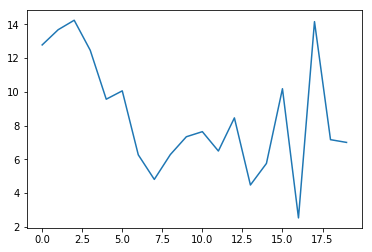

7.487647945960132 11.26625912967662
______NOOKS_________
DAY 20


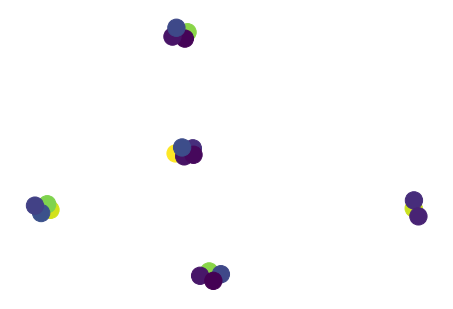

______NETWORK_________


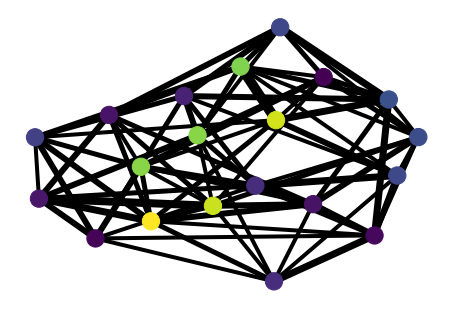

[4. 5. 4. 5. 4. 6. 8. 4. 5.]
[4. 5. 5. 4. 6. 4. 6. 5.]
[5. 5. 5. 5. 5. 6. 7. 6. 4.]
[4. 5. 6. 6. 6. 5. 4. 4. 4.]
[ 5.  4. 10.  7.  6.  4.  4.]
[ 5. 10.  5.  6.  5.  5.  4.  4.  4.]
[5. 6. 7. 5. 5. 5. 5. 4. 4.]
[6. 4. 4. 5. 6. 4. 6.]
[7. 5. 5. 6. 7. 7. 5. 4.]
[5. 5. 6. 4. 5. 6. 6. 5.]
[4. 4. 5. 4. 7. 4. 4.]
[6. 7. 4. 4. 4. 6. 5.]
[6. 6. 5. 5. 5. 4. 4. 6. 6.]
[6. 5. 5. 6. 4. 6. 5.]
[4. 5. 7. 6. 6. 5. 4.]
[8. 6. 7. 5. 6. 6. 4.]
[5. 4. 7. 7. 6. 6. 4. 4.]
[4. 5. 6. 4. 5. 5. 4. 5.]
[5. 5. 6. 4. 5. 4. 4. 4. 4.]
[6. 5. 4. 5. 6. 5. 5. 4.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  11.429108
2     [19.26465904742651]  17.170606
3    [15.901117053967454]  11.926133
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   6.309736
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   6.278914
9    [1.2635963070241618]  10.409856
10    [2.664800067471699]   9.817581
11    [4.46069548744

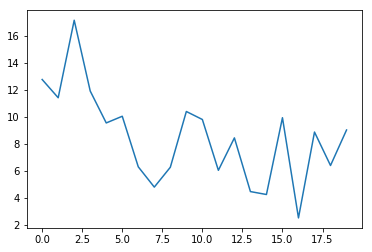

8.963148391825495 11.441703107277599
______NOOKS_________
DAY 21


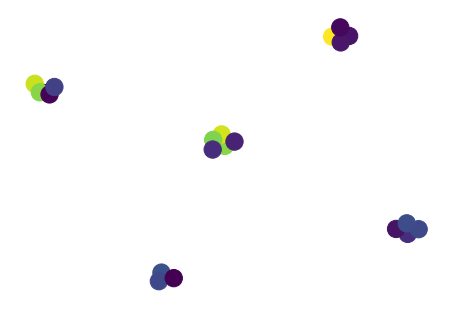

______NETWORK_________


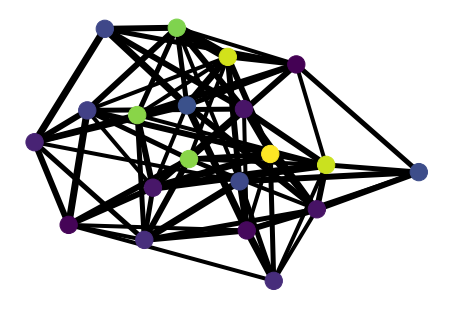

[4. 5. 4. 6. 4. 6. 8. 4. 5.]
[4. 5. 5. 6. 6. 6. 4.]
[5. 5. 6. 5. 5. 6. 7. 6. 4.]
[4. 5. 6. 6. 6. 5. 4. 4. 4. 4.]
[ 6.  4.  4. 10.  7.  6.  5.  4.]
[ 5. 10.  5.  6.  6.  6.  4.  4.]
[5. 6. 7. 5. 5. 5. 6. 4.]
[6. 4. 4. 6. 6. 4. 7.]
[7. 5. 6. 6. 7. 7. 5. 4.]
[6. 5. 6. 4. 5. 6. 6. 4. 5.]
[4. 5. 4. 5. 7. 4.]
[6. 7. 5. 4. 4. 4. 6. 6.]
[6. 6. 5. 6. 5. 4. 4. 6. 6.]
[6. 5. 6. 6. 4. 7. 6.]
[6. 7. 6. 7. 5.]
[8. 6. 7. 5. 6. 6. 4. 4.]
[6. 4. 7. 4. 7. 6. 6. 4. 4.]
[4. 6. 6. 5. 5. 5. 4. 5.]
[5. 6. 6. 4. 5.]
[6. 5. 4. 6. 7. 5. 6. 4.]
                        0          1
0    [17.727350755167564]  12.779908
1    [15.859326575161054]  11.429108
2     [19.26465904742651]  14.114866
3    [15.901117053967454]  11.926133
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   6.309736
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   4.901456
9    [1.2635963070241618]  10.409856
10    [2.664800067471699]   7.537855
11    [4.460695487448303]   4.18

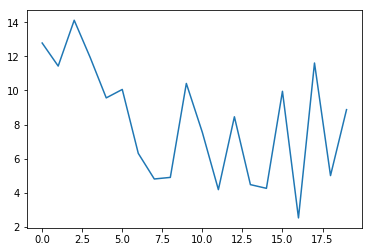

8.664875263869881 10.995404281423133
______NOOKS_________
DAY 22


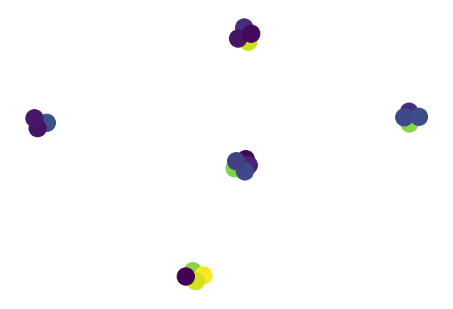

______NETWORK_________


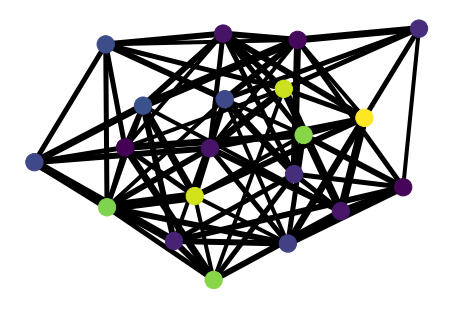

[4. 5. 4. 7. 5. 6. 8. 4. 5.]
[4. 5. 5. 6. 6. 7. 4.]
[5. 5. 6. 5. 5. 6. 8. 7. 4.]
[4. 5. 6. 6. 5. 7. 5. 4. 4.]
[ 6.  4.  4. 10.  7.  4.  6.  5.  4.]
[ 5. 10.  5.  6.  7.  5.  6.  4.  4.  4.]
[5. 6. 5. 7. 5. 5. 5. 7.]
[6. 5. 4. 6. 6. 5. 7.]
[7. 5. 6. 6. 7. 8. 5. 4.]
[7. 5. 4. 6. 5. 6. 6. 5. 4.]
[5. 5. 4. 5. 7.]
[6. 7. 5. 4. 4. 4. 6. 6. 4.]
[6. 6. 5. 5. 6. 5. 6. 6. 4.]
[6. 5. 6. 6. 4. 4. 8. 6.]
[7. 7. 6. 8. 5. 5.]
[8. 6. 8. 5. 6. 6. 4. 5.]
[7. 5. 8. 7. 6. 6. 4. 4. 4.]
[4. 7. 7. 5. 5. 5. 4. 4. 5.]
[5. 5. 6. 6. 5. 4. 5.]
[7. 5. 4. 6. 7. 5. 4. 6. 5.]
                        0          1
0    [17.727350755167564]  15.484957
1    [15.859326575161054]  11.429108
2     [19.26465904742651]  14.114866
3    [15.901117053967454]  14.191555
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.122119
6     [2.773493752303742]   6.469803
7   [0.41013089019082294]   4.808692
8     [4.963525873735796]   4.901456
9    [1.2635963070241618]  10.409856
10    [2.664800067471699]   7.537855
11   

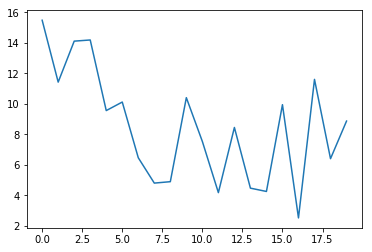

8.664875263869881 13.253063559347899
______NOOKS_________
DAY 23


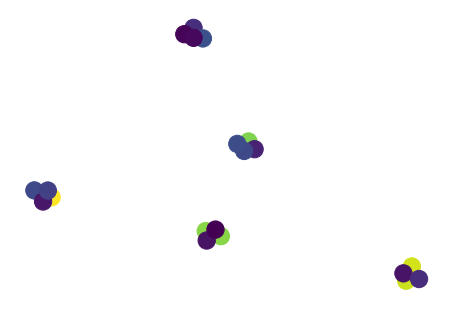

______NETWORK_________


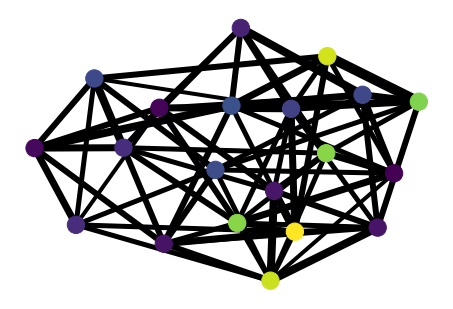

[5. 5. 5. 8. 5. 6. 8. 4. 5.]
[5. 5. 5. 5. 6. 6. 7.]
[5. 5. 6. 5. 5. 7. 8. 7.]
[5. 5. 5. 6. 6. 5. 5. 7. 5.]
[ 6. 10.  7.  6.  5.  5.]
[ 5. 10.  6.  6.  7.  5.  6.]
[5. 6. 5. 8. 6. 5. 5. 7.]
[6. 5. 4. 6. 4. 6. 6. 7.]
[7. 6. 6. 6. 7. 5. 8. 5.]
[8. 5. 5. 6. 5. 6. 6. 5.]
[5. 5. 4. 5. 7. 5.]
[6. 8. 5. 6. 6. 4.]
[6. 7. 5. 6. 6. 5. 6. 6.]
[6. 5. 6. 6. 8. 7.]
[7. 4. 7. 6. 8. 6. 5.]
[8. 6. 8. 5. 6. 5. 6. 5.]
[7. 6. 8. 7. 6. 6.]
[4. 7. 7. 5. 5. 6. 5.]
[5. 5. 5. 6. 6. 5. 5.]
[7. 5. 5. 6. 7. 5. 7. 5. 4.]
                        0          1
0    [17.727350755167564]  15.484957
1    [15.859326575161054]  11.751623
2     [19.26465904742651]  14.114866
3    [15.901117053967454]  14.718786
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   6.309736
7   [0.41013089019082294]   4.391693
8     [4.963525873735796]   6.454441
9    [1.2635963070241618]  10.409856
10    [2.664800067471699]   7.482252
11    [4.460695487448303]   4.183772
12   [1.21046812846076

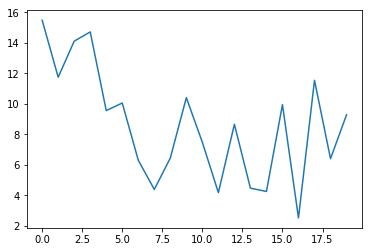

8.973219164919648 13.416141746037894
______NOOKS_________
DAY 24


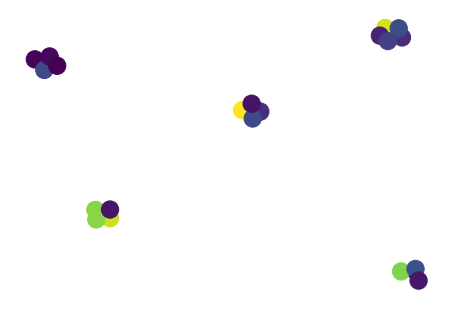

______NETWORK_________


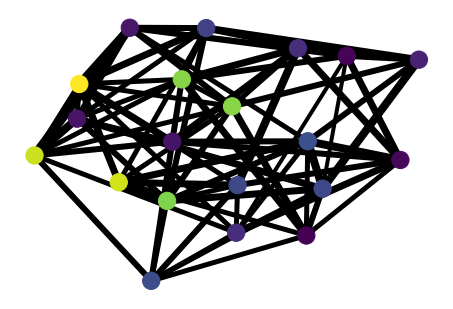

[5. 5. 5. 8. 5. 6. 9. 6.]
[5. 5. 5. 5. 6. 5. 6. 6. 7.]
[5. 5. 7. 7. 8. 7. 5. 5. 5. 5.]
[5. 5. 5. 7. 6. 5. 6. 7. 5.]
[ 5.  7. 11.  7.  7.  5.  5.]
[ 6. 11.  6.  6.  5.  7.  5.  6.]
[5. 7. 5. 8. 7. 6. 5. 7.]
[6. 5. 4. 6. 4. 6. 7. 7.]
[7. 6. 5. 6. 6. 8. 5. 8. 5.]
[8. 5. 6. 5. 5. 7. 6. 5.]
[5. 4. 5. 5. 5. 5. 7. 5.]
[7. 5. 8. 5. 5. 6. 6.]
[6. 7. 6. 7. 6. 5. 6. 6.]
[6. 6. 6. 6. 8. 7.]
[7. 4. 8. 7. 5. 8. 6. 5.]
[9. 6. 8. 5. 6. 5. 6. 6.]
[7. 7. 8. 7. 6. 6. 5.]
[7. 7. 5. 5. 6. 5. 5.]
[6. 5. 5. 6. 6. 5. 5.]
[7. 5. 5. 6. 7. 5. 7. 6.]
                        0          1
0    [17.727350755167564]  15.484957
1    [15.859326575161054]  11.429108
2     [19.26465904742651]  14.114866
3    [15.901117053967454]  14.718786
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   3.829647
7   [0.41013089019082294]   4.391693
8     [4.963525873735796]   6.454441
9    [1.2635963070241618]  10.409856
10    [2.664800067471699]   7.582818
11    [4.460695487448303]  

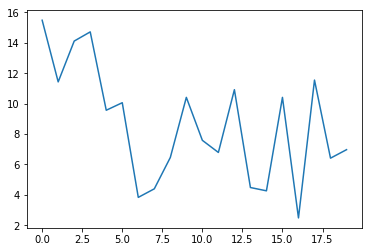

8.57271874364388 13.853953231314199
______NOOKS_________
DAY 25


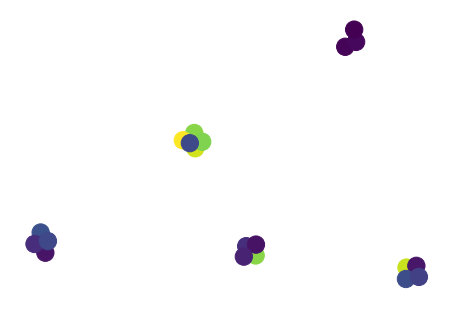

______NETWORK_________


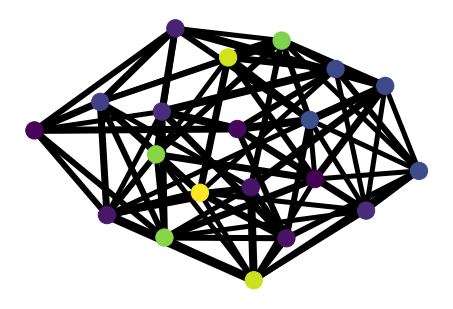

[5. 5. 5. 8. 5. 6. 9. 5. 6.]
[5. 6. 5. 5. 6. 5. 6. 6. 7.]
[5. 6. 7. 7. 8. 7. 5. 5. 5.]
[5. 5. 7. 6. 6. 7. 6. 5. 5. 4.]
[ 5.  7. 11.  7.  7.  6.  5.]
[ 6. 11.  6.  6.  5.  5.  7.  5.  6.]
[5. 7. 5. 8. 7. 7. 5. 8.]
[6. 5. 6. 6. 7. 7.]
[7. 6. 6. 6. 8. 8. 5. 5. 5. 5.]
[8. 6. 5. 5. 6. 7. 6. 5.]
[5. 5. 5. 5. 5. 5. 7. 5.]
[7. 5. 8. 5. 5. 6. 6.]
[6. 7. 6. 7. 6. 6. 6. 6.]
[6. 5. 7. 6. 6. 8. 7.]
[7. 8. 7. 5. 8. 7. 5.]
[9. 6. 8. 5. 6. 6. 4. 5. 7.]
[8. 7. 8. 7. 6. 6. 5.]
[5. 7. 7. 6. 7. 5. 5. 5.]
[6. 5. 5. 6. 6. 5. 5. 5.]
[7. 6. 5. 6. 7. 5. 7. 7.]
                        0          1
0    [17.727350755167564]  15.967123
1    [15.859326575161054]   9.493008
2     [19.26465904742651]  11.195720
3    [15.901117053967454]  14.191555
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   3.829647
7   [0.41013089019082294]   4.391693
8     [4.963525873735796]   6.454441
9    [1.2635963070241618]   6.820269
10    [2.664800067471699]   9.834751
11    [4.46069

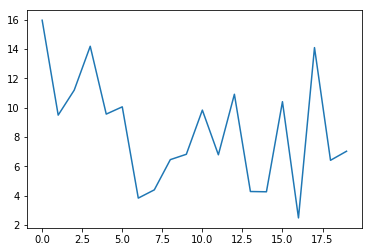

8.260068237855624 13.485263705119184
______NOOKS_________
DAY 26


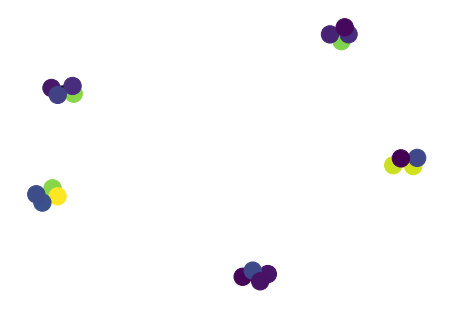

______NETWORK_________


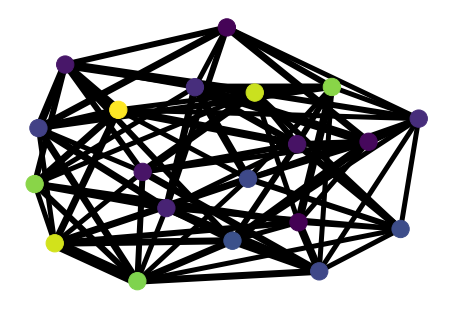

[5. 5. 5. 8. 6. 6. 9. 5. 6.]
[5. 7. 6. 7. 6. 7. 5. 5.]
[5. 7. 7. 8. 8. 7. 5. 5.]
[5. 7. 6. 6. 8. 6. 5. 5. 5.]
[ 7.  5. 11.  7.  5.  7.  6.  5.]
[ 6. 11.  7.  6.  5.  5.  7.  5.  7.]
[7. 5. 5. 8. 7. 7. 5. 9.]
[6. 5. 5. 6. 6. 7. 7.]
[7. 7. 6. 6. 8. 6. 8. 5. 5.]
[8. 5. 6. 6. 7. 6. 5. 5.]
[6. 5. 5. 5. 5. 5. 5. 7. 5.]
[7. 5. 8. 5. 5. 5. 6. 6.]
[6. 8. 6. 7. 6. 6. 5. 6. 7.]
[7. 5. 7. 6. 6. 5. 8. 5. 7.]
[7. 8. 7. 5. 8. 5. 8. 5.]
[9. 6. 8. 5. 6. 6. 6. 8.]
[9. 7. 8. 7. 6. 6. 5. 5.]
[5. 7. 8. 6. 8. 5. 5. 5.]
[6. 5. 5. 6. 7. 5. 5. 5.]
[7. 6. 5. 7. 7. 7. 8. 5.]
                        0          1
0    [17.727350755167564]  15.484957
1    [15.859326575161054]   9.493008
2     [19.26465904742651]  11.195720
3    [15.901117053967454]  14.191555
4     [17.94350025061847]   9.562619
5    [15.603874503510516]  10.057705
6     [2.773493752303742]   3.829647
7   [0.41013089019082294]   4.391693
8     [4.963525873735796]   6.454441
9    [1.2635963070241618]   6.820269
10    [2.664800067471699]   9.834751
1

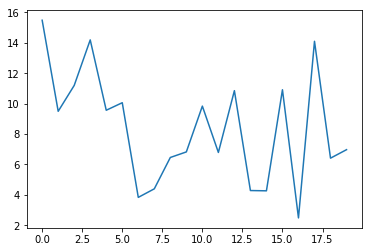

8.230343982809929 13.238061675119502
______NOOKS_________
DAY 27


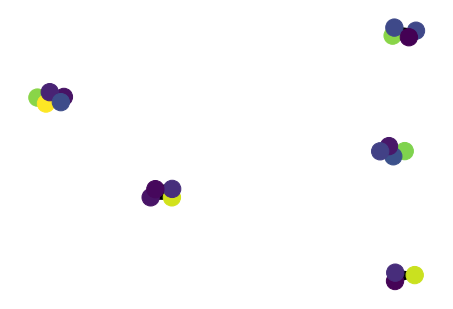

In [25]:
# control case
exp = NooksExperiment(member_vectors, alpha=0, swipe_mode='all')
exp.run(num_nooks=5)